# Double Jet

With various grid sizes

In [1]:
from gpuocean.SWEsimulators import ModelErrorKL, CDKLM16
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
gpu_stream = cuda.Stream()

In [4]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

Get initial arguments from class

In [5]:
from gpuocean.utils import DoubleJetCase

In [6]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=512, nx=1024)
doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

## Truth

In [7]:
from gpuocean.utils import Observation, DrifterPlotHelper

In [8]:
truth_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetTruth/2023-11-02T09_33_29"

true_trajectories = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                            domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                            nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

true_trajectories.read_pickle(os.path.join(truth_path, "truth_trajectories.pickle"))

In [9]:
true_trajectories.get_num_drifters()

100

## Ensemble drifter

In [10]:
slda_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetSLDA/2023-11-10T11_44_24"

slda_drifter_path = os.path.join(slda_path, "sldrifters_60")

slda_trajectories = []
for f in os.listdir(slda_drifter_path):
    if f.startswith("sl"):
        trajectory = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                                domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                                nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

        trajectory.read_pickle(os.path.join(slda_drifter_path,f))
        
        slda_trajectories.append(trajectory)



slda_trajectories2 = []
for f in os.listdir(slda_drifter_path):
    if f.startswith("ml"):
        trajectory = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                                domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                                nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

        trajectory.read_pickle(os.path.join(slda_drifter_path,f))
        
        slda_trajectories2.append(trajectory)

In [11]:
mlda_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetMLDA/2023-11-09T18_07_14"
mlda_drifter_path = os.path.join(mlda_path, "mldrifters_60")

# mlda_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetMLDA/2023-11-08T15_45_28"
# mlda_drifter_path = os.path.join(mlda_path, "mldrifters")

mlda_trajectories = []
for f in os.listdir(mlda_drifter_path):
    trajectory = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                            domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                            nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

    trajectory.read_pickle(os.path.join(mlda_drifter_path,f))
    
    mlda_trajectories.append(trajectory)

## Drifters

## KDE

/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layo

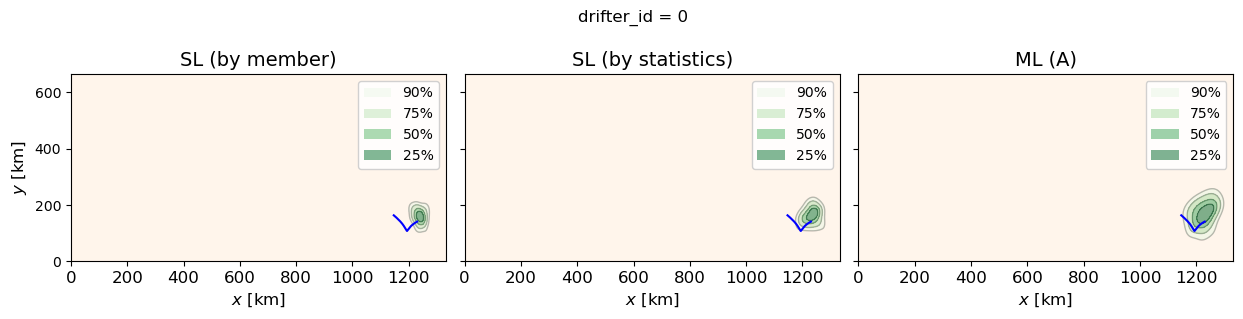

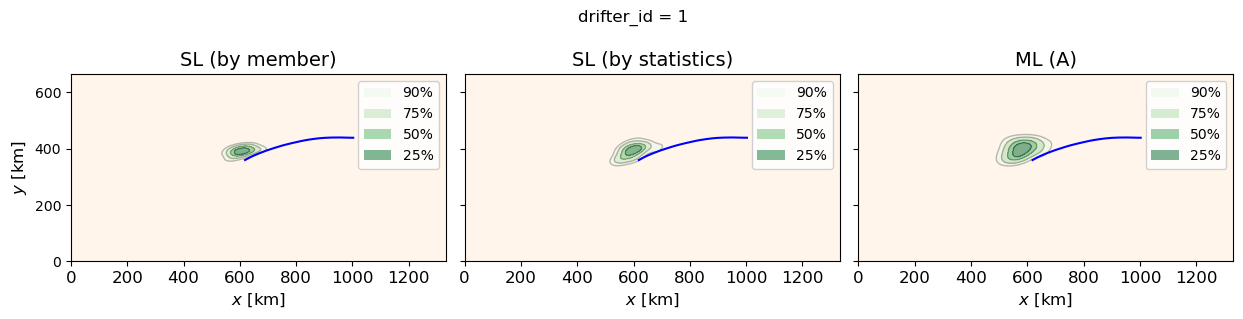

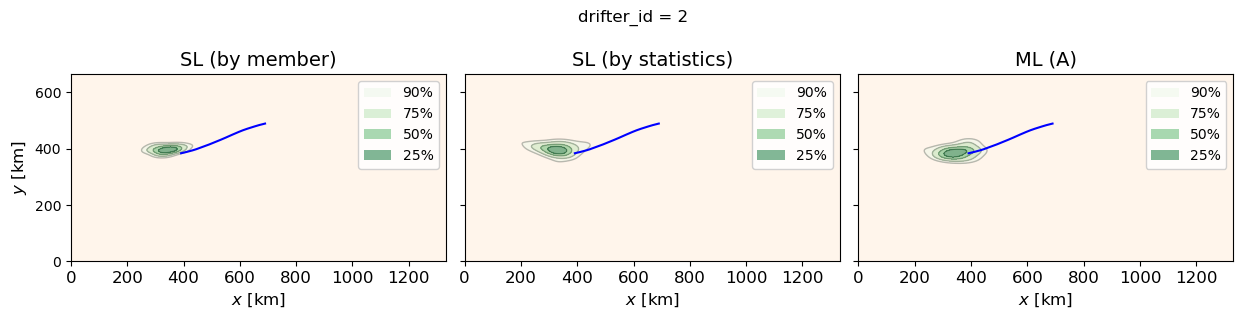

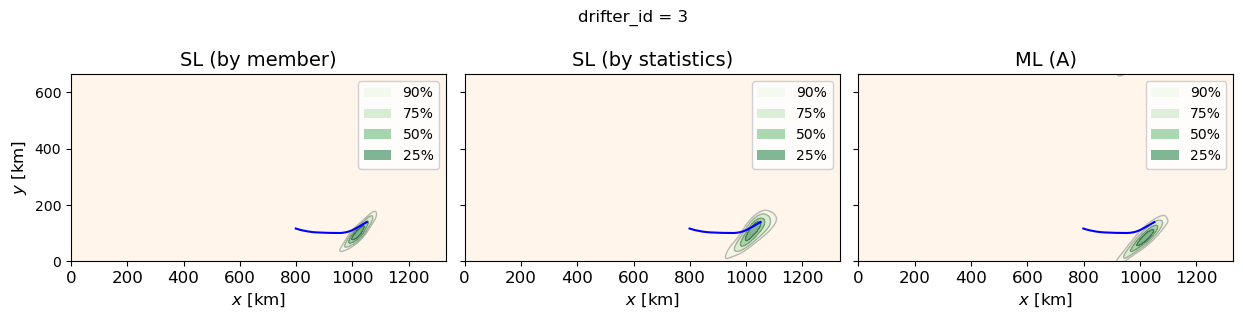

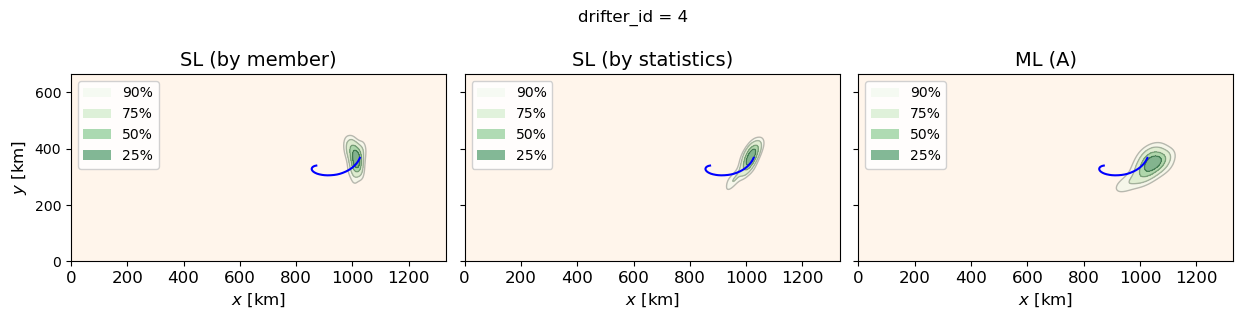

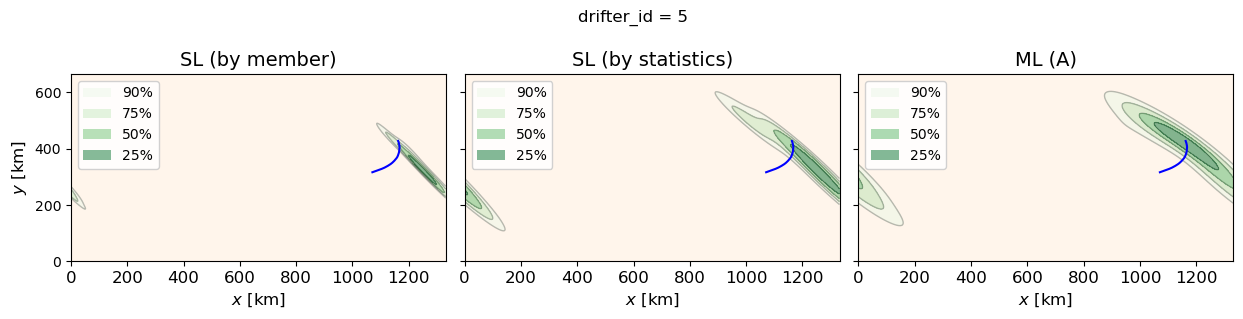

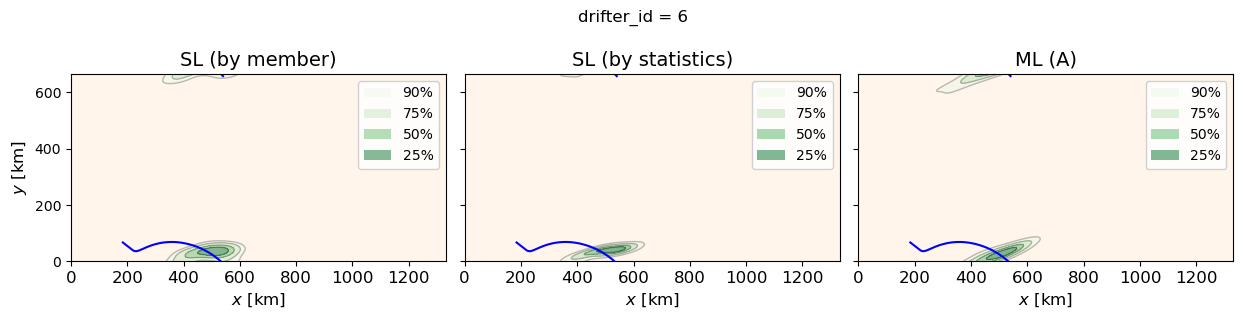

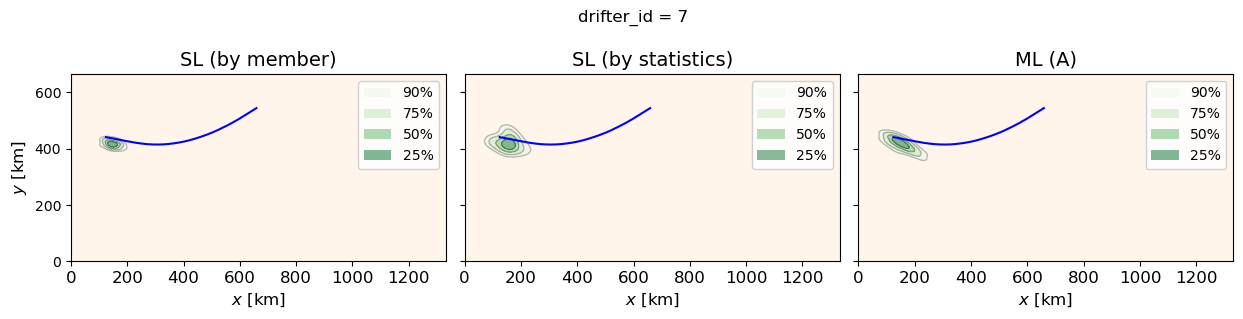

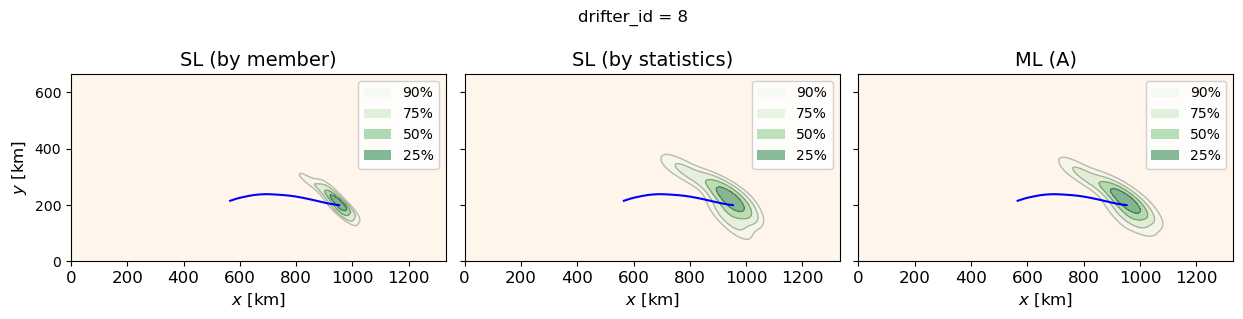

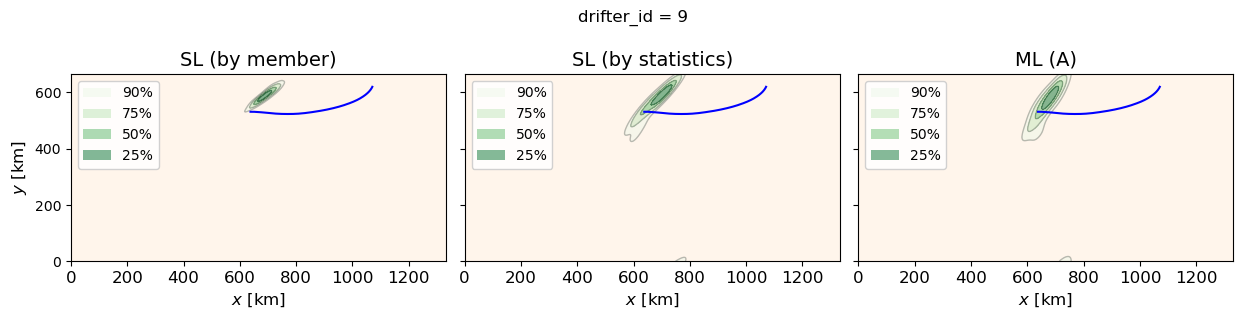

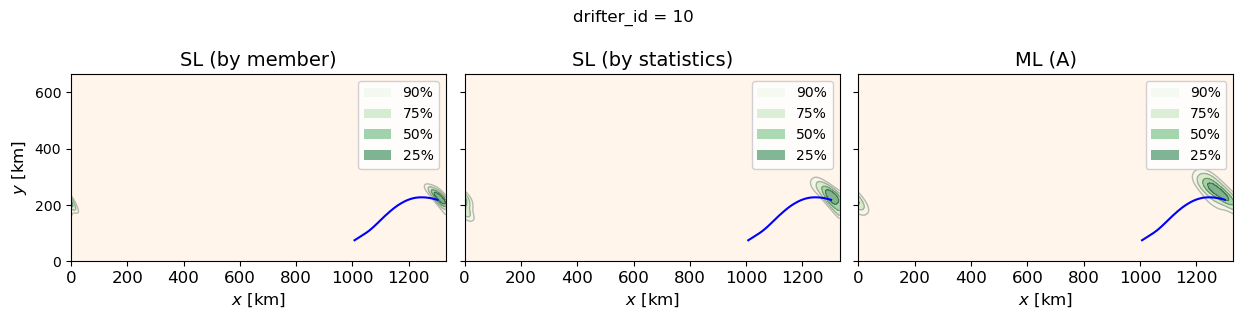

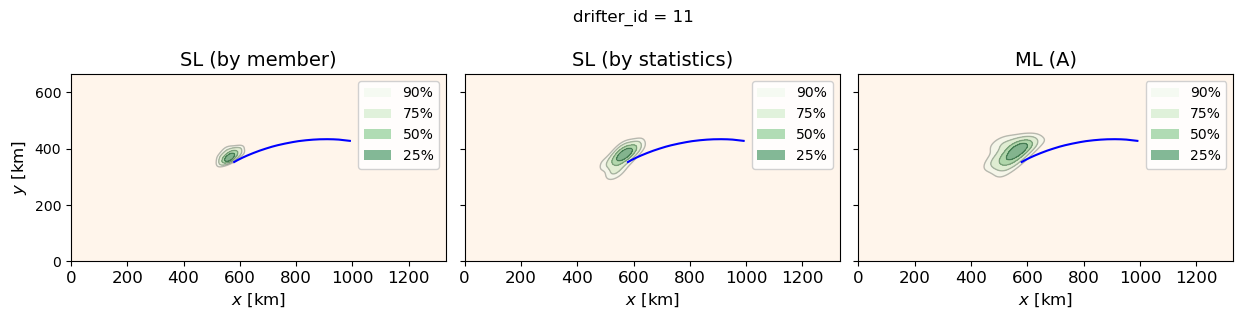

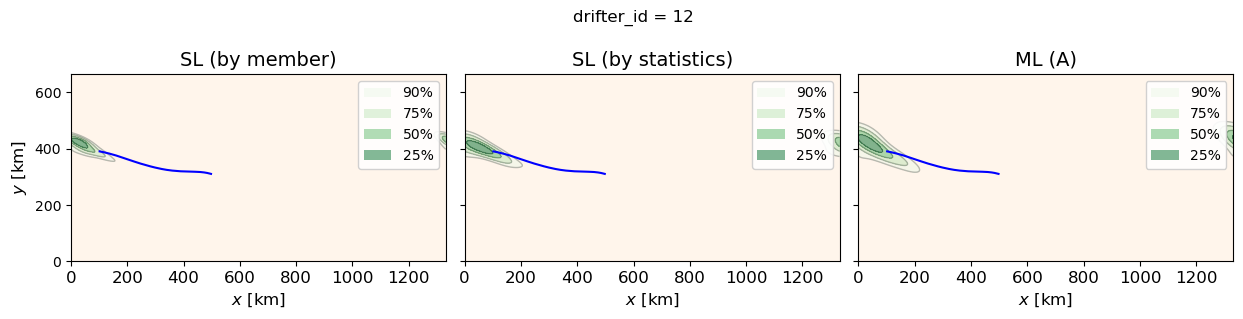

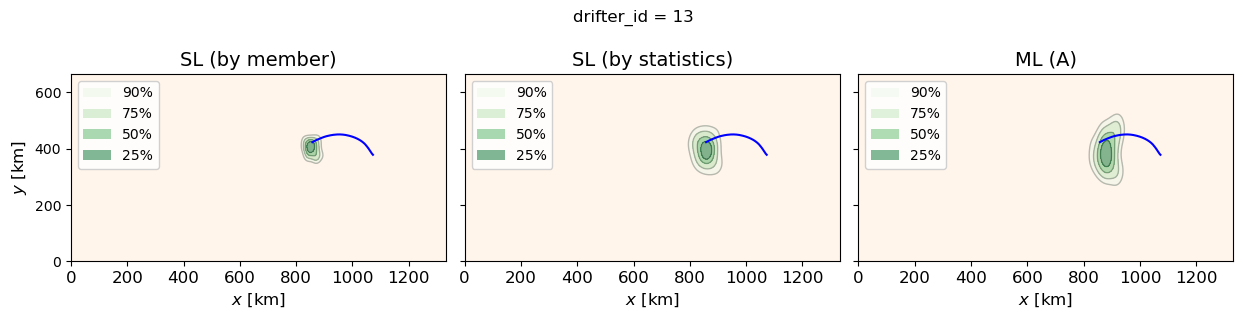

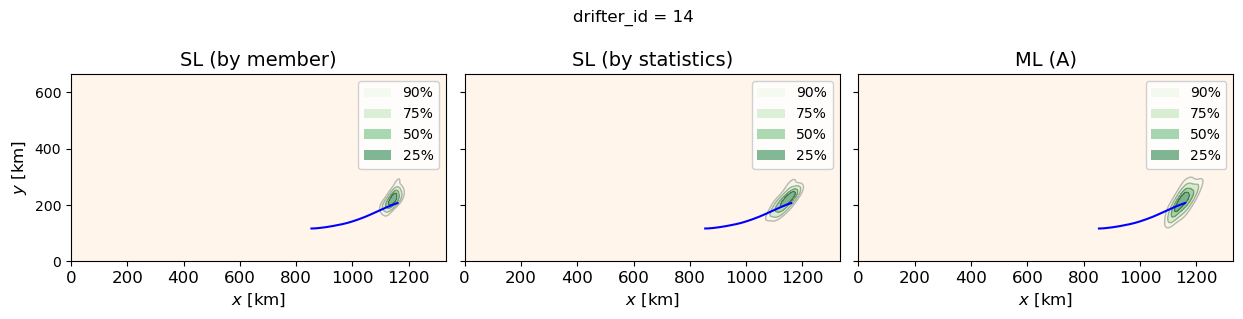

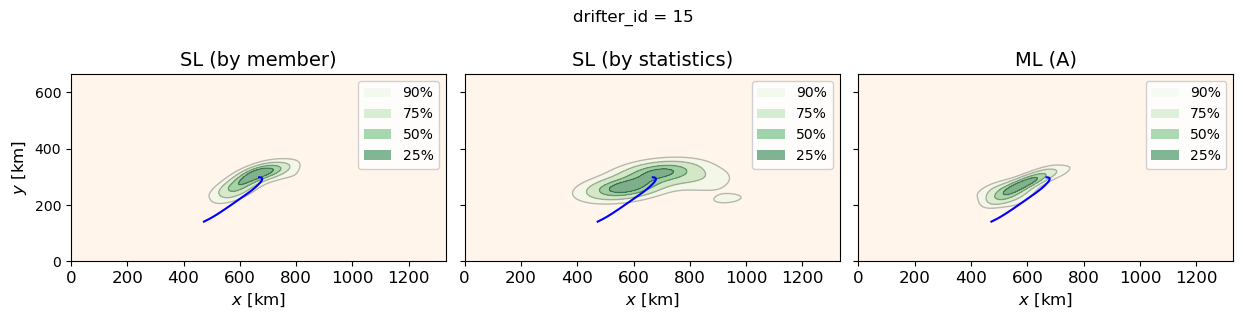

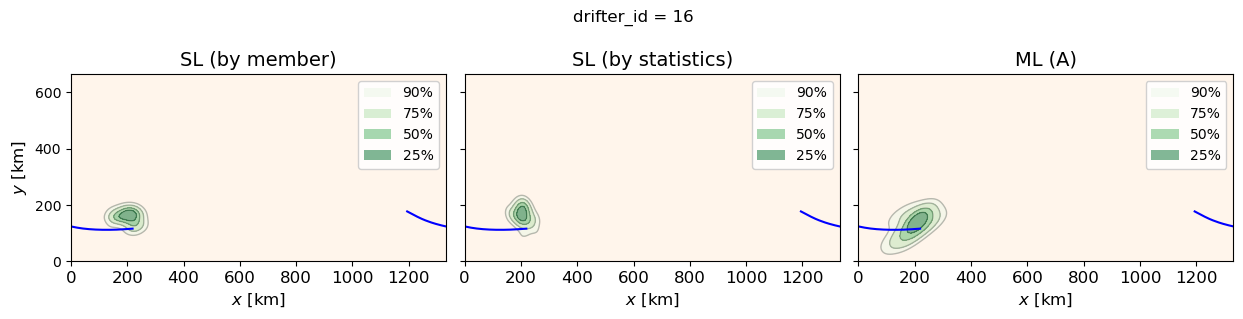

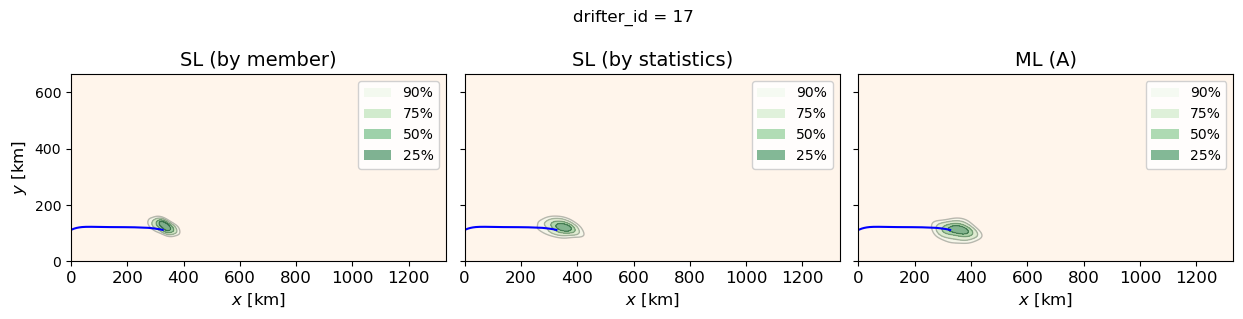

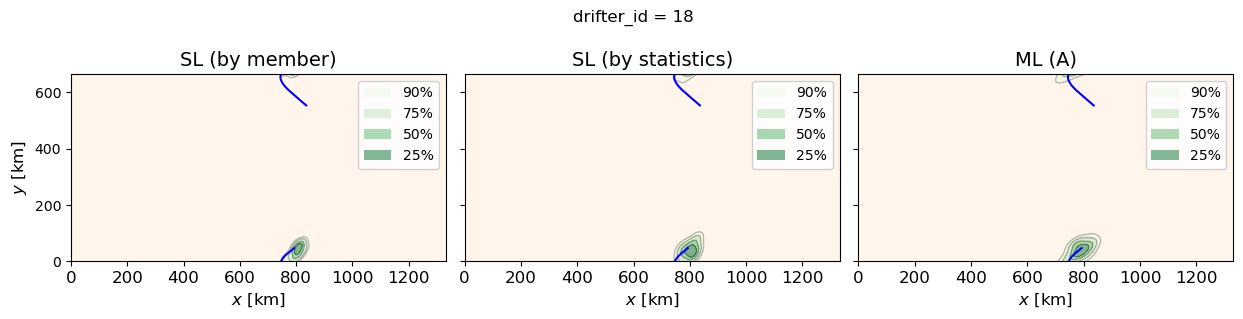

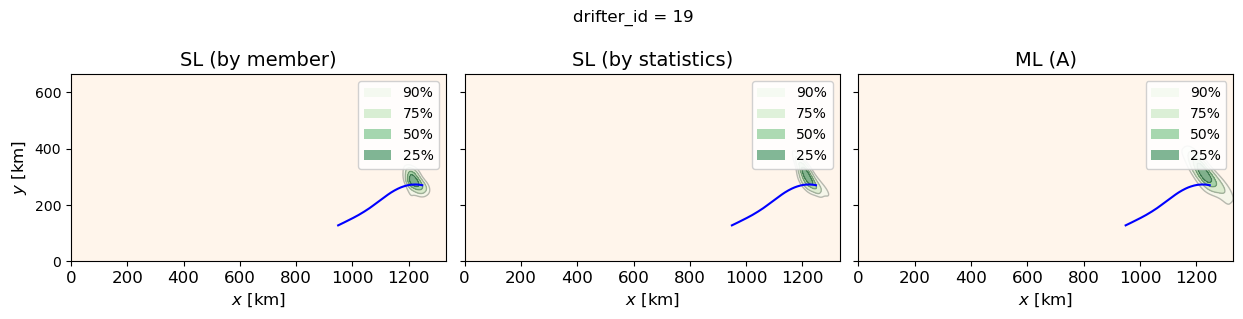

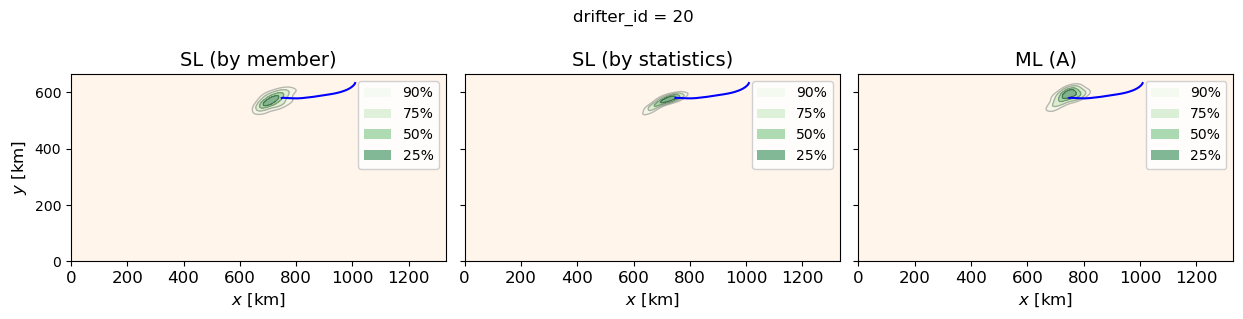

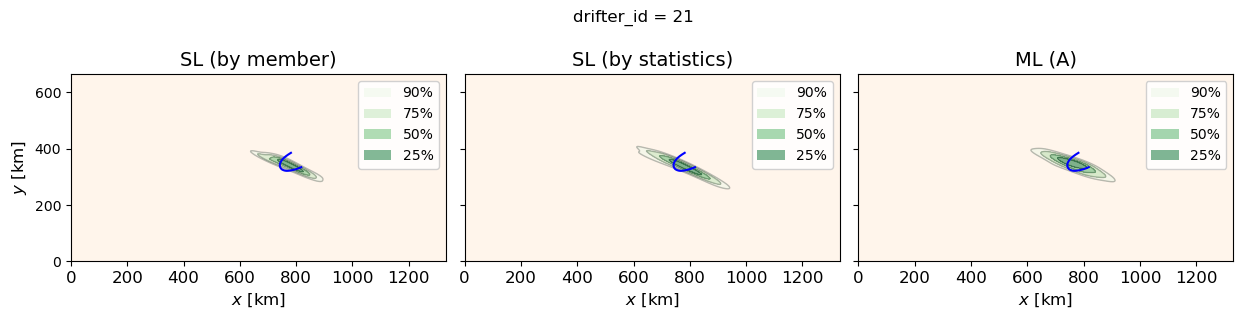

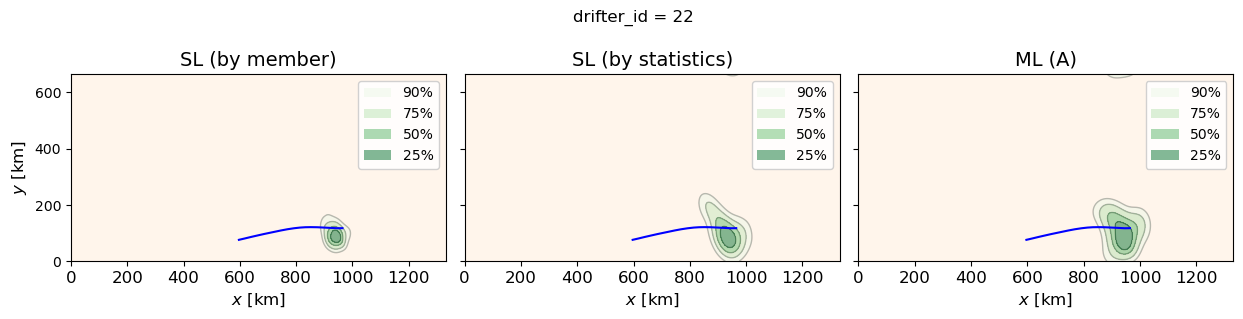

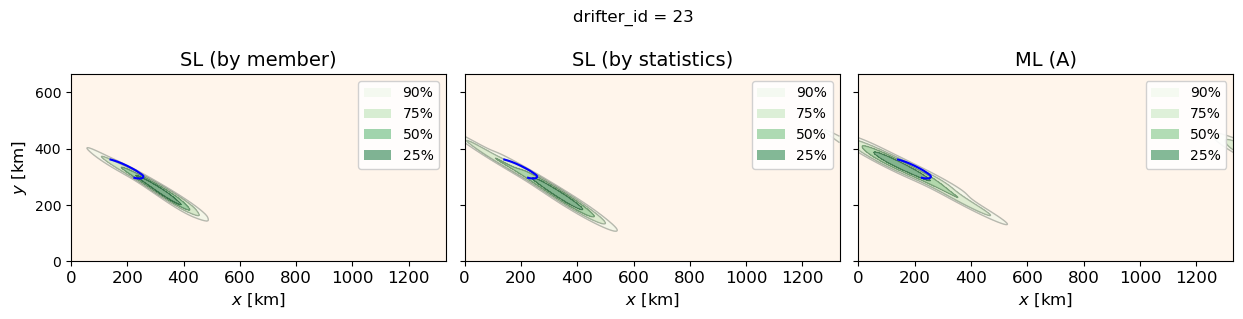

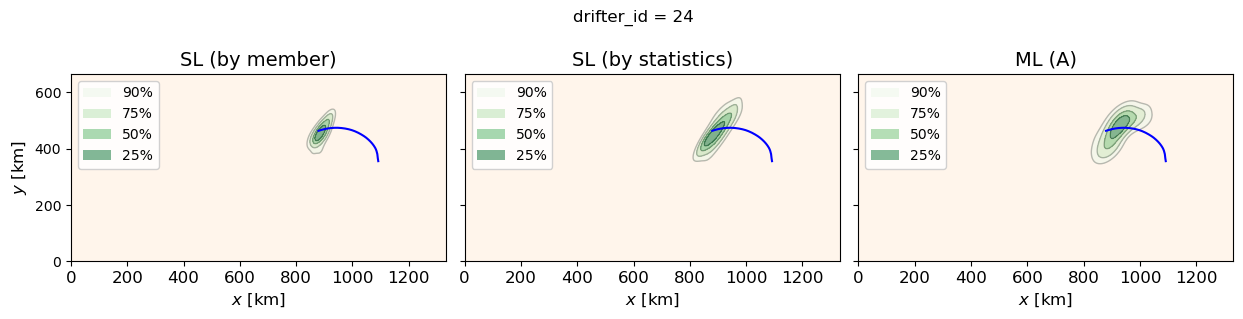

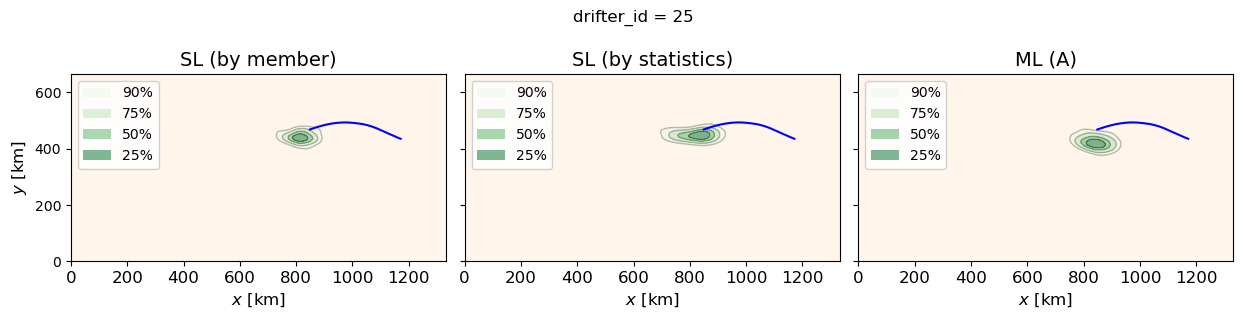

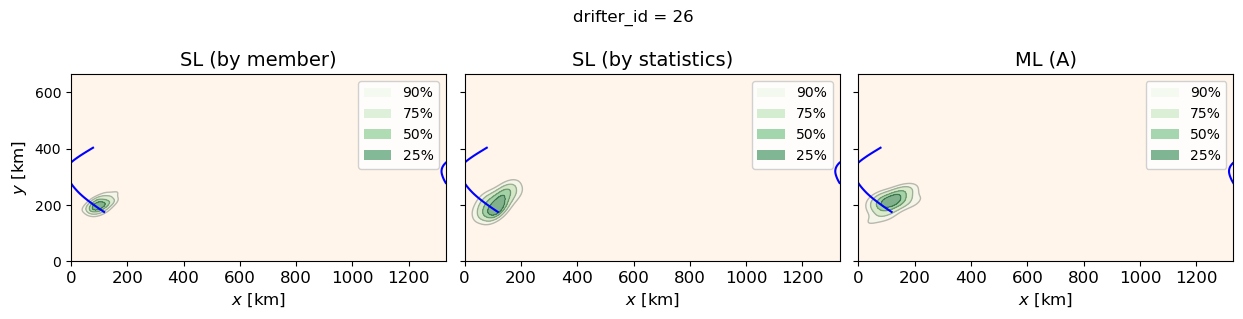

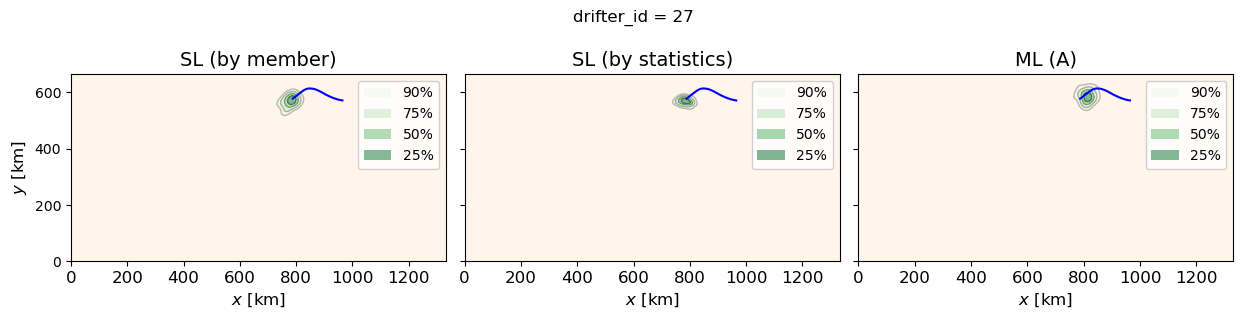

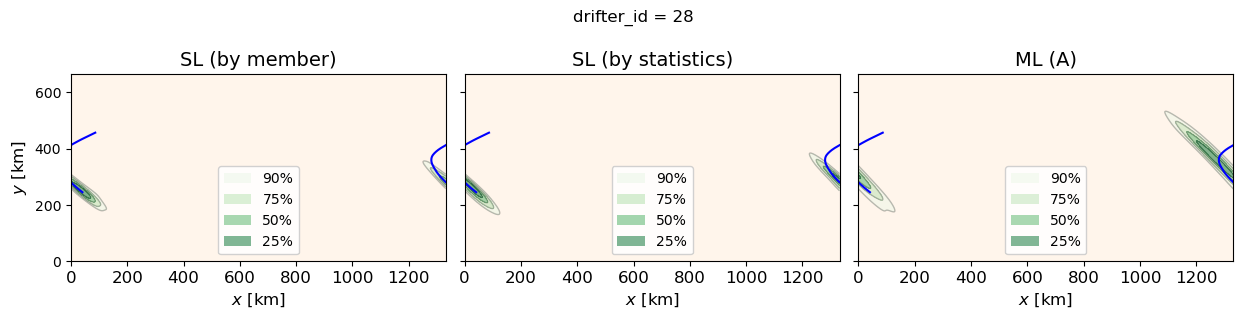

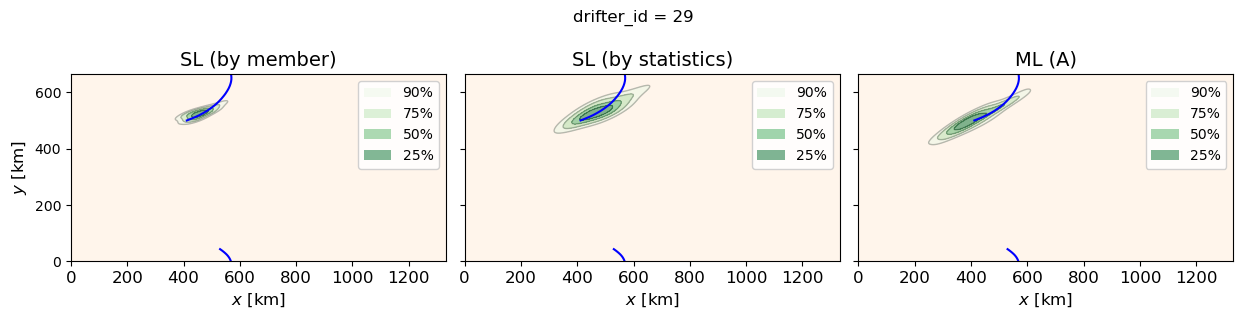

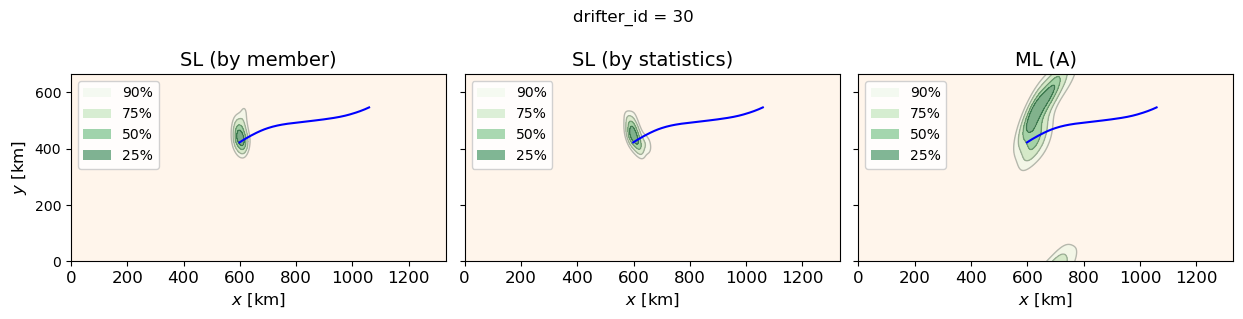

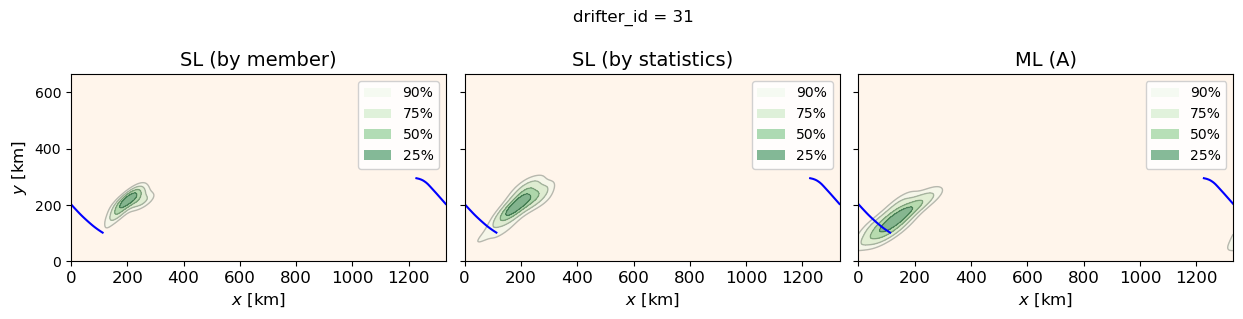

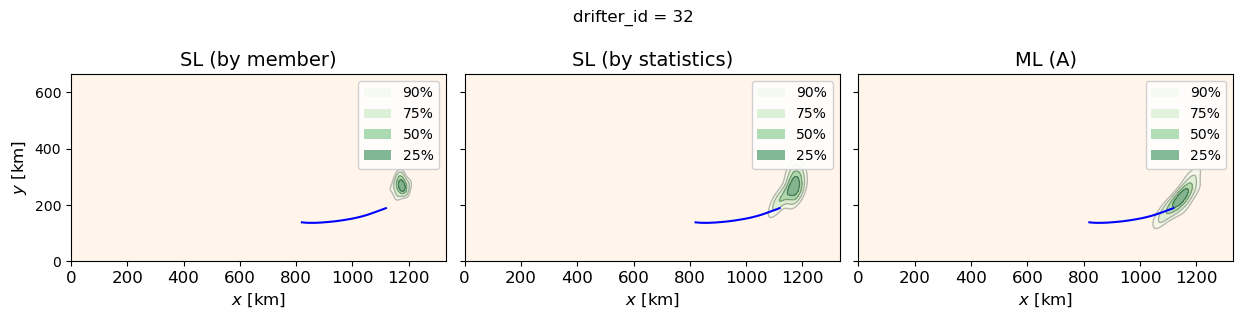

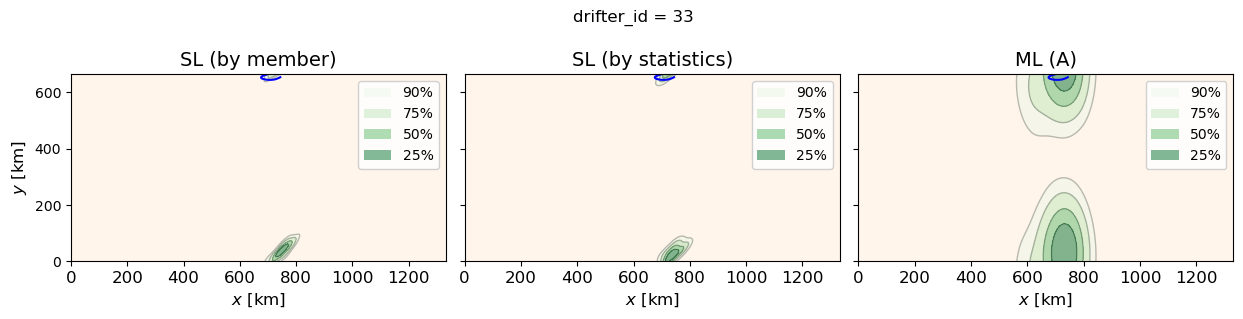

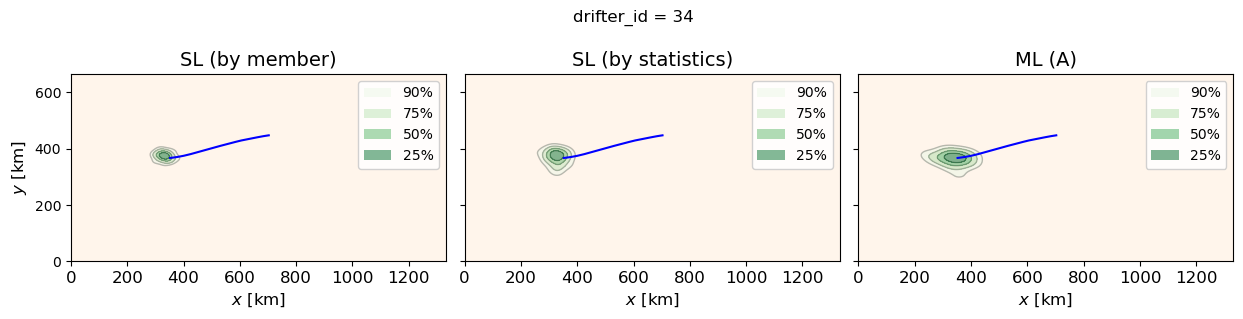

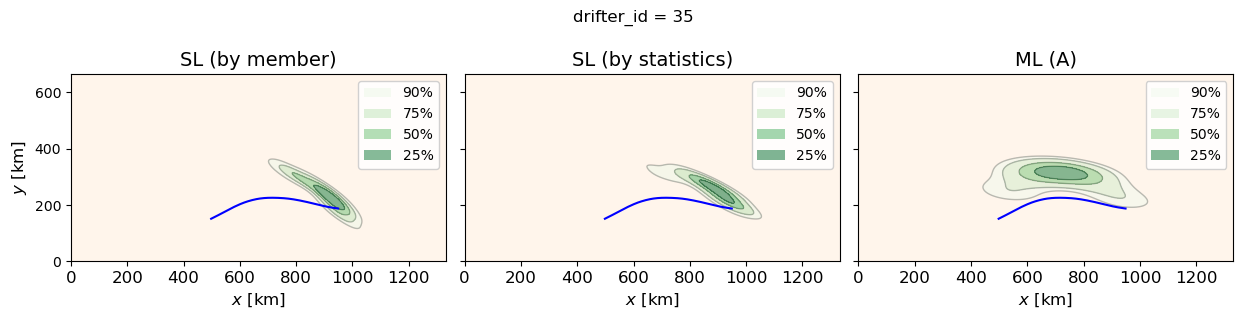

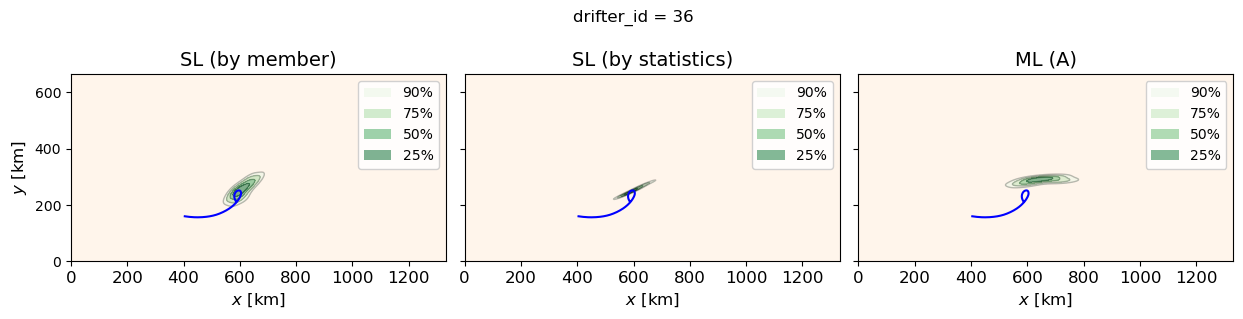

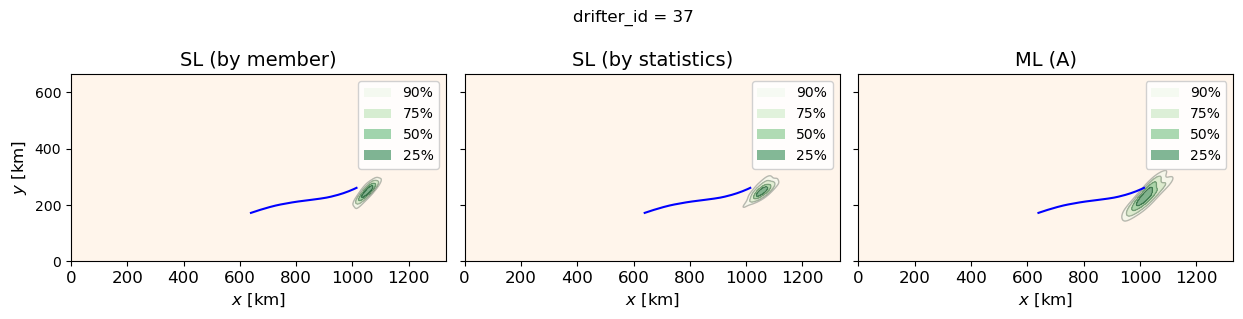

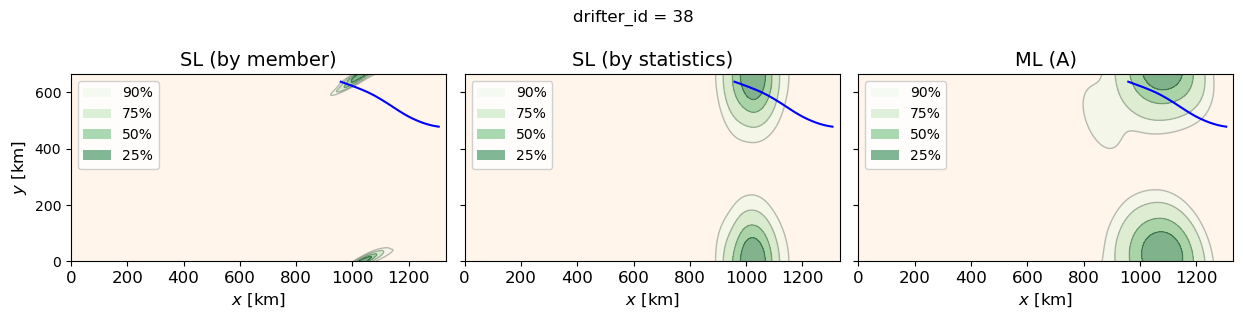

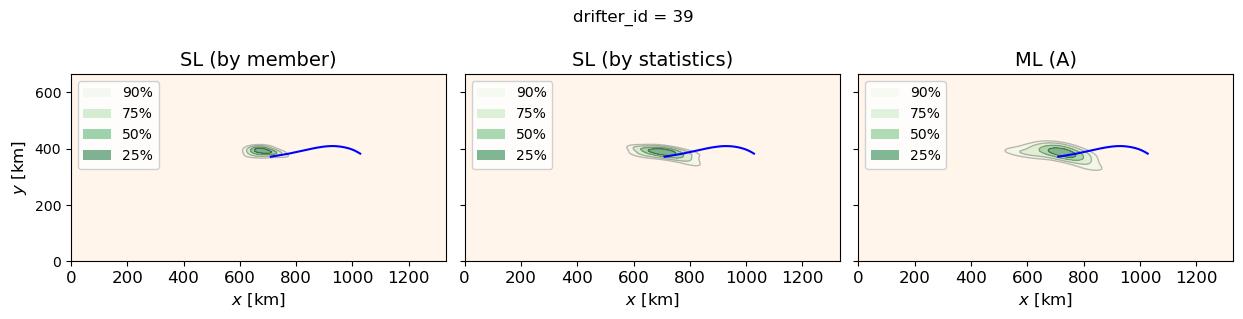

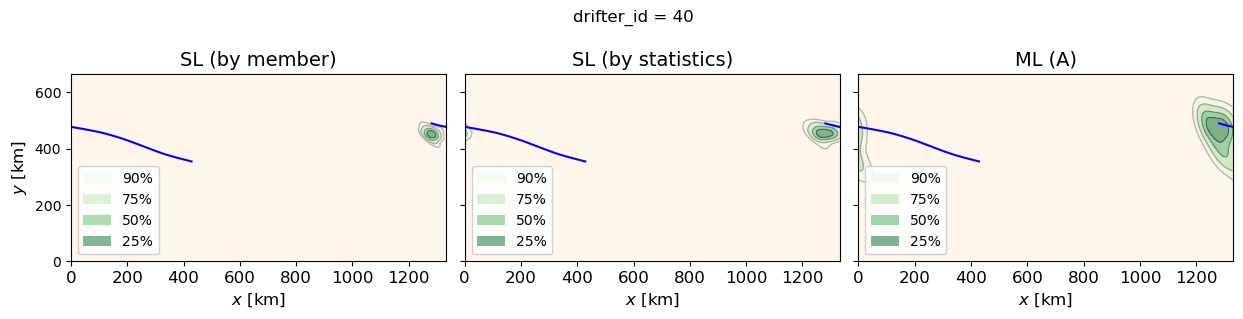

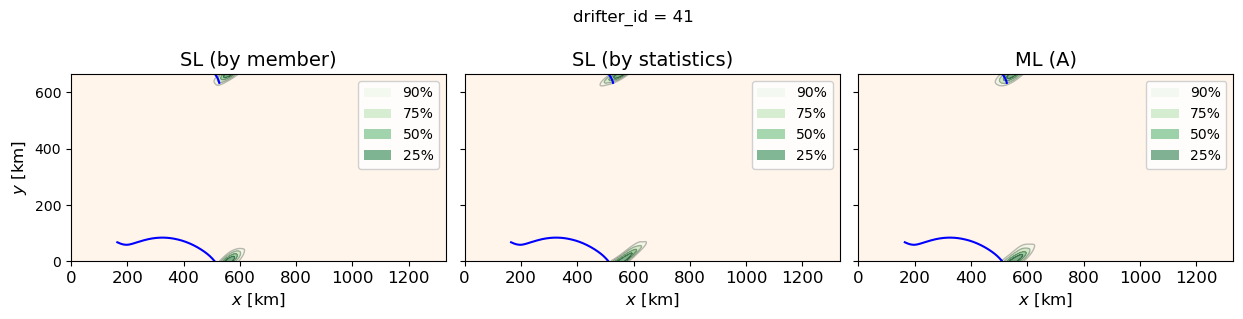

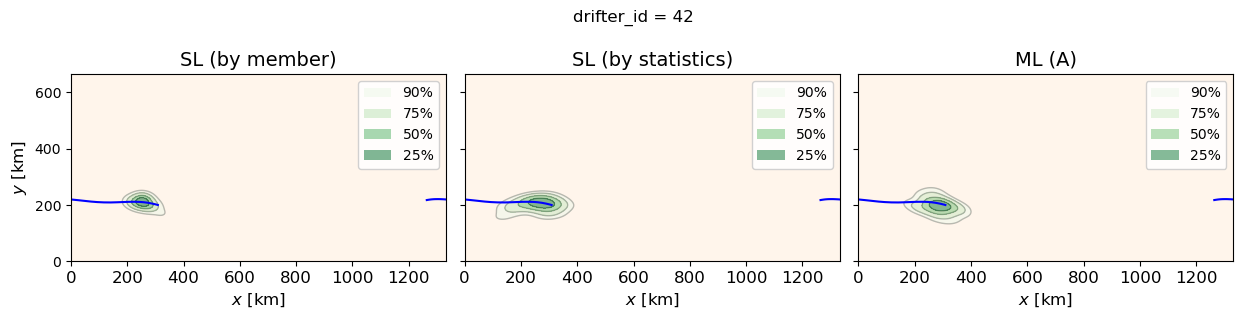

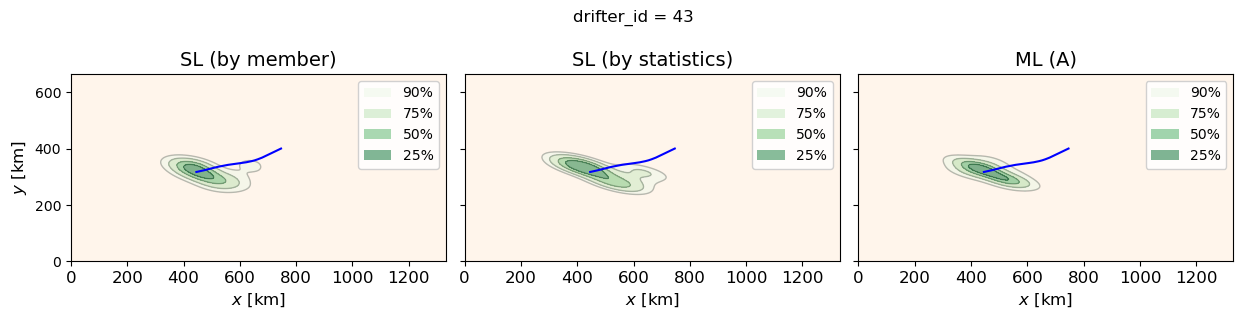

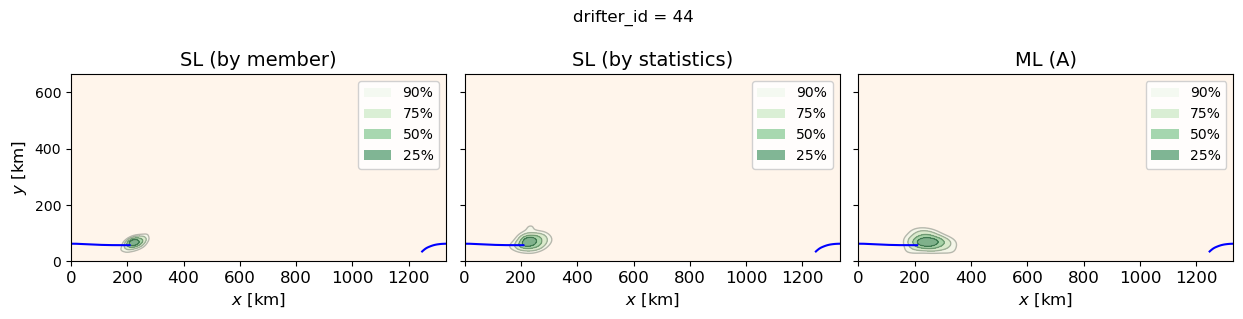

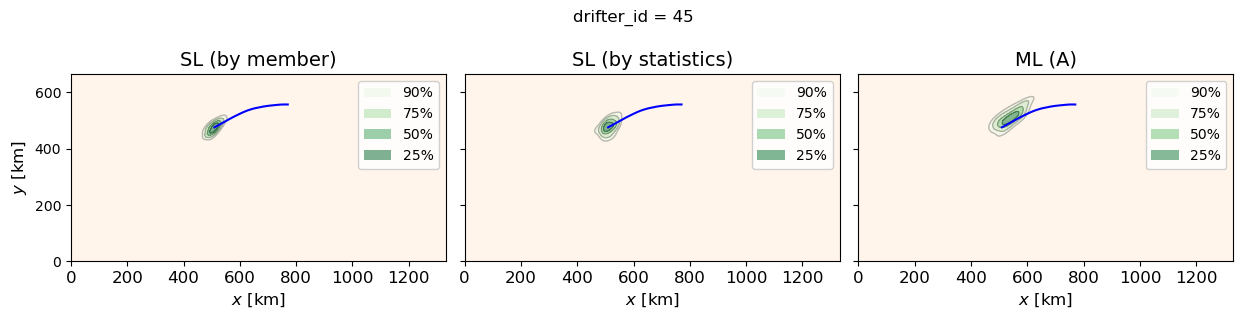

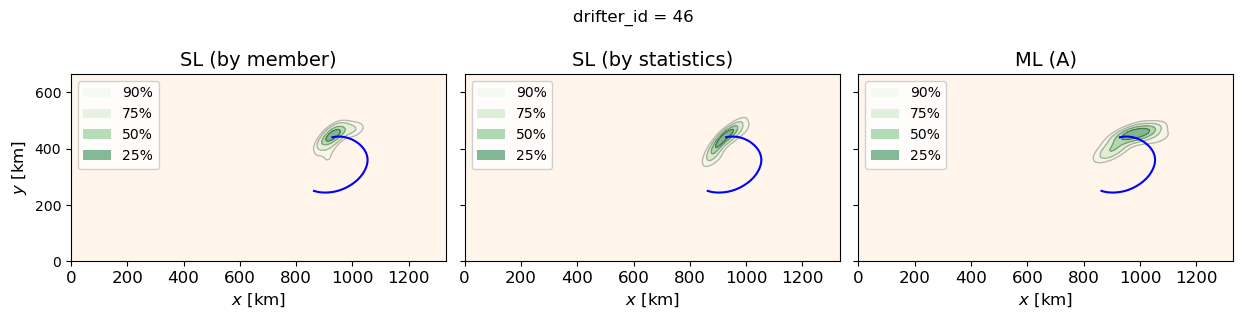

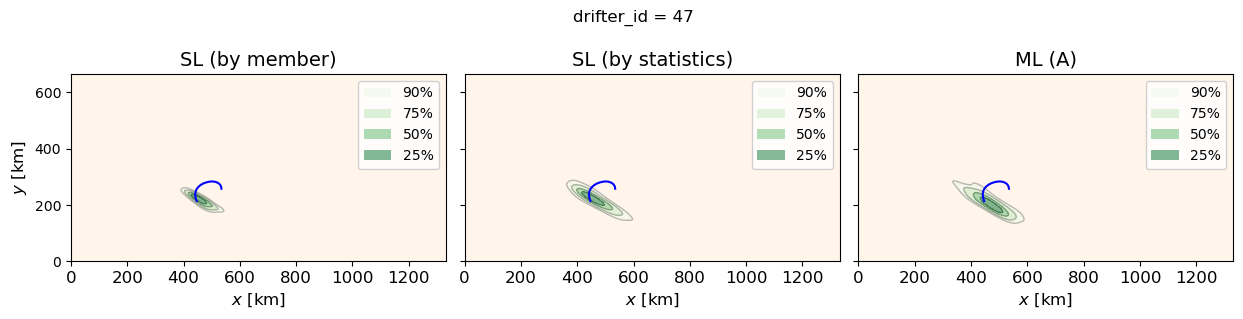

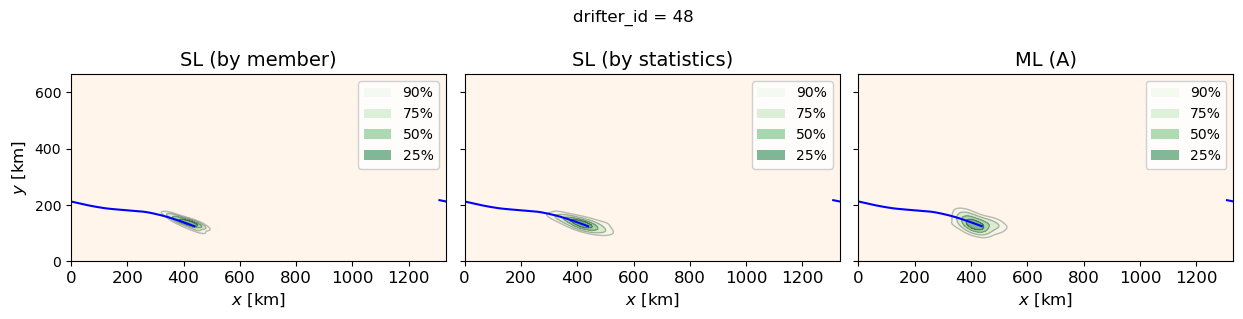

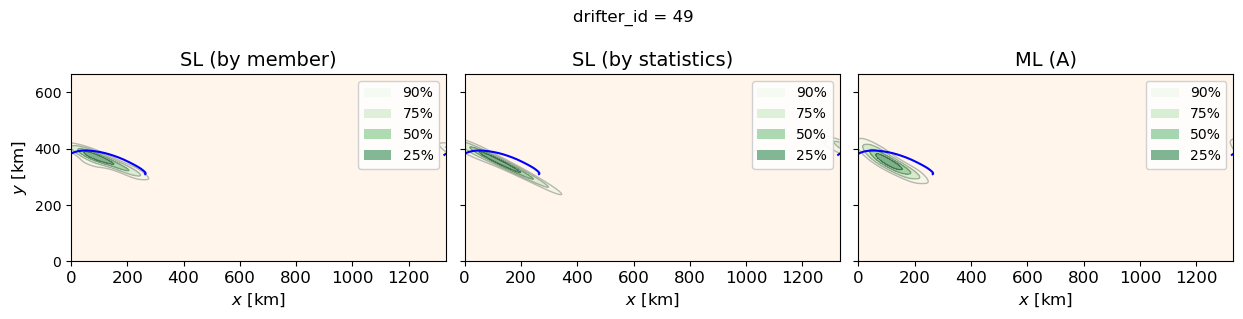

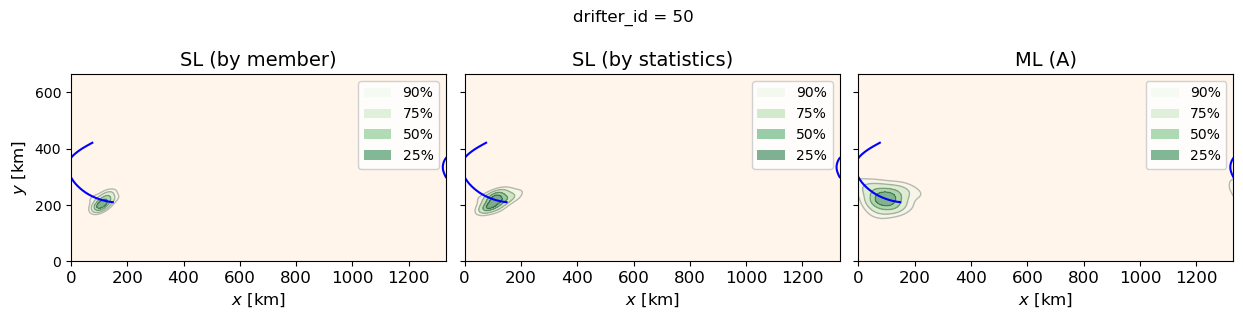

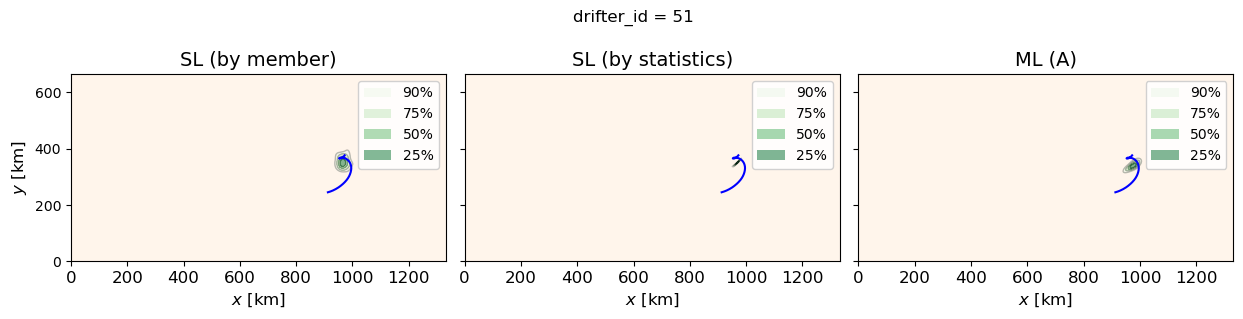

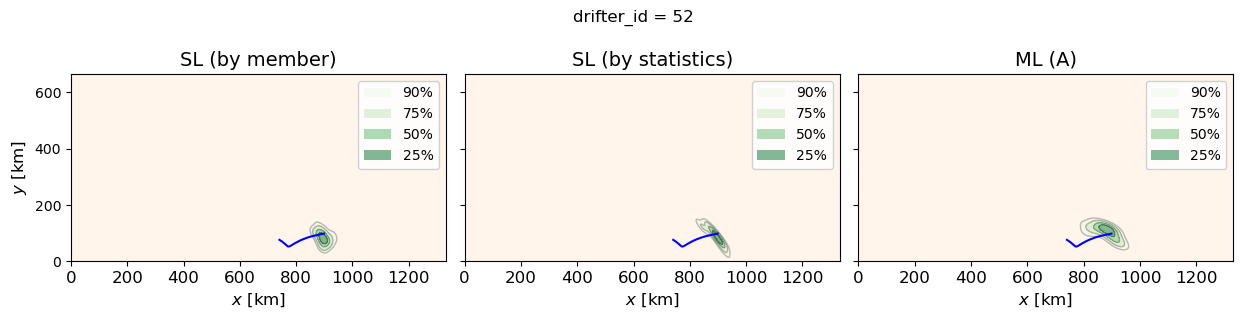

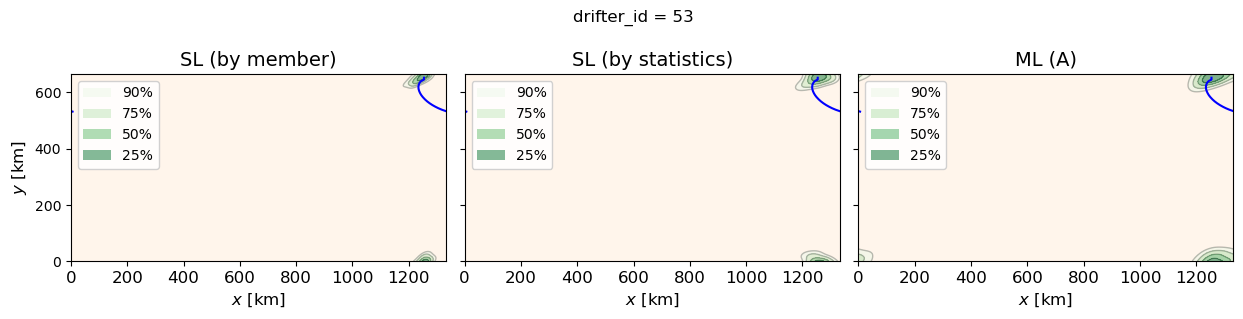

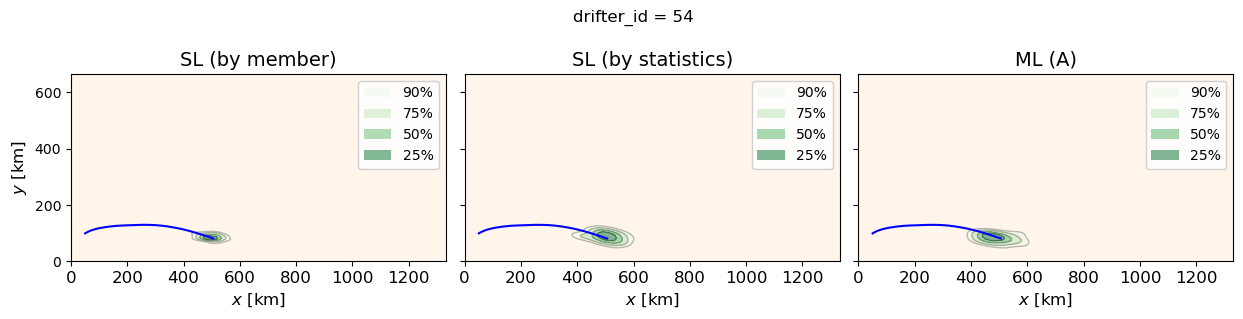

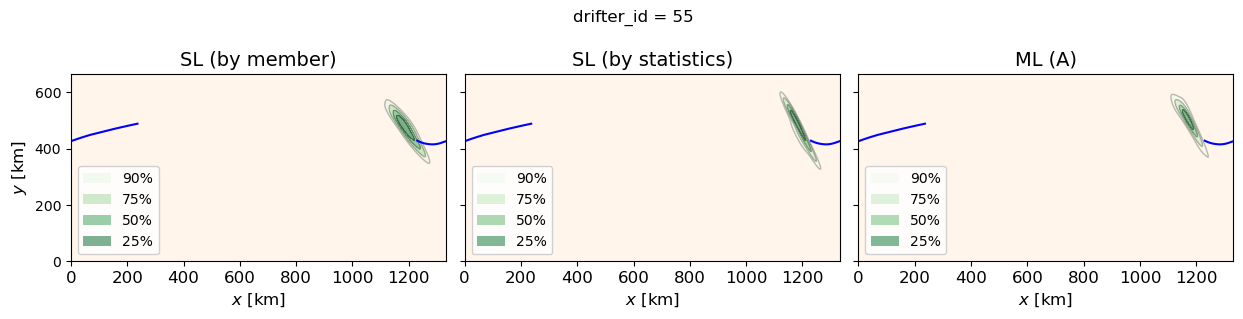

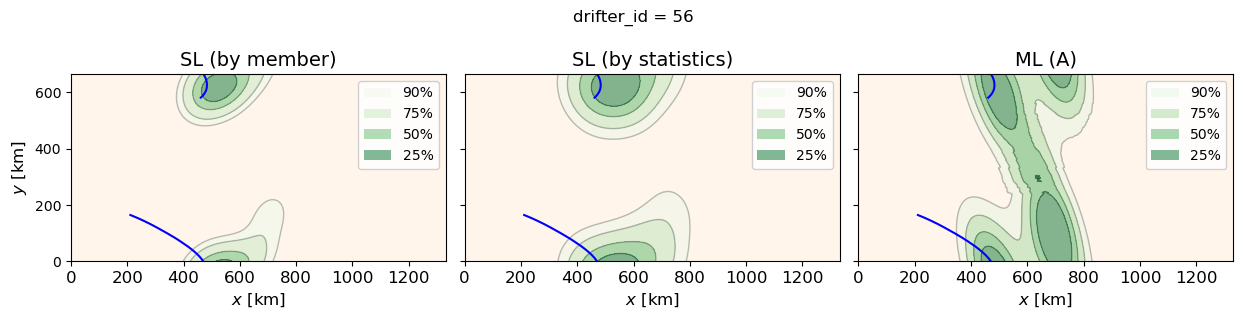

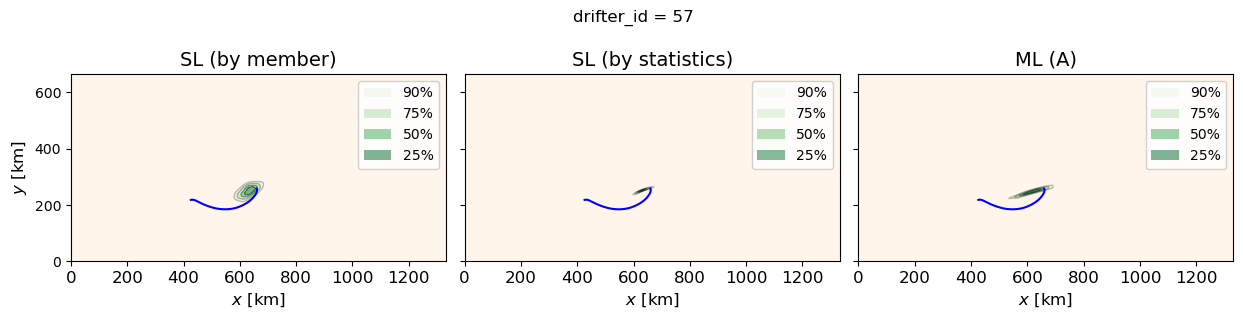

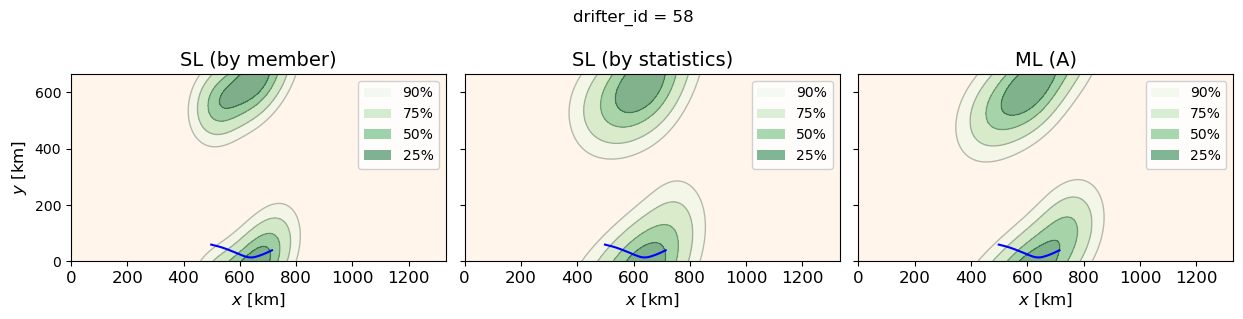

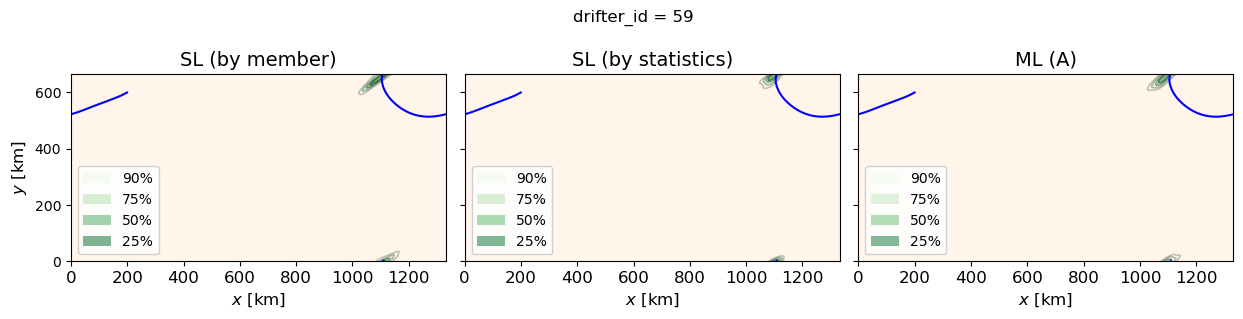

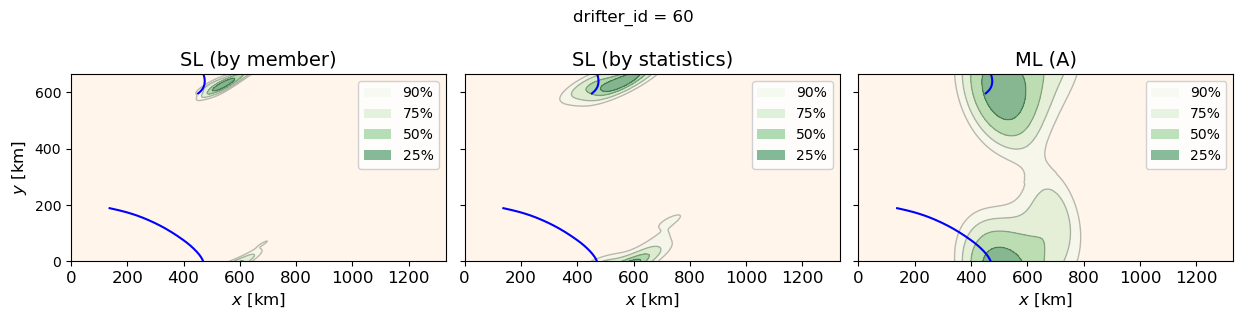

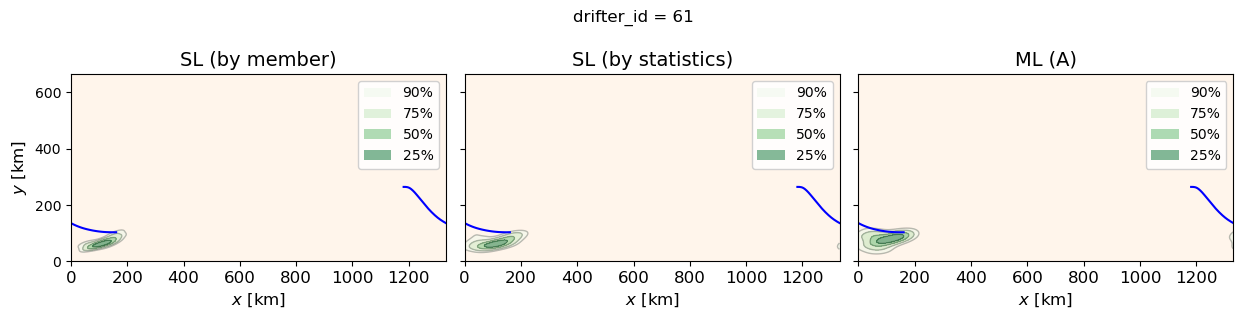

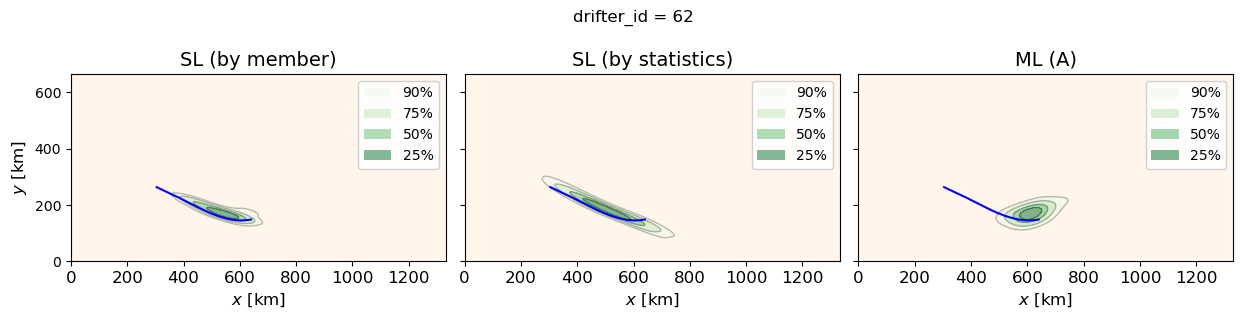

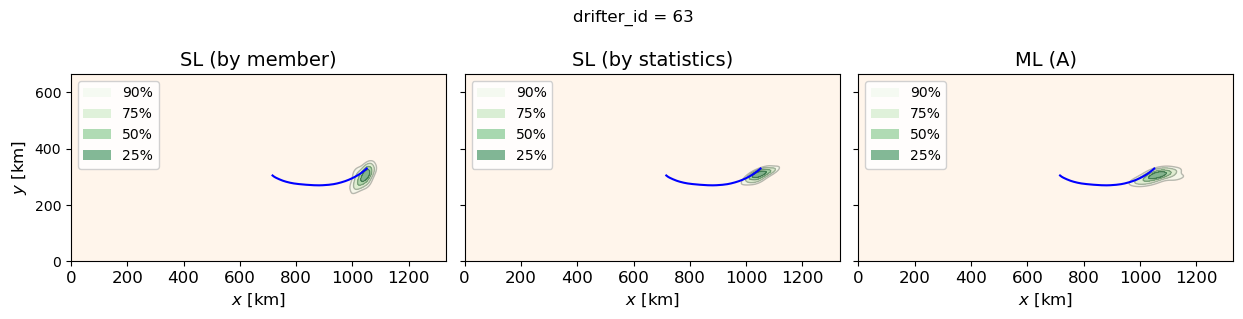

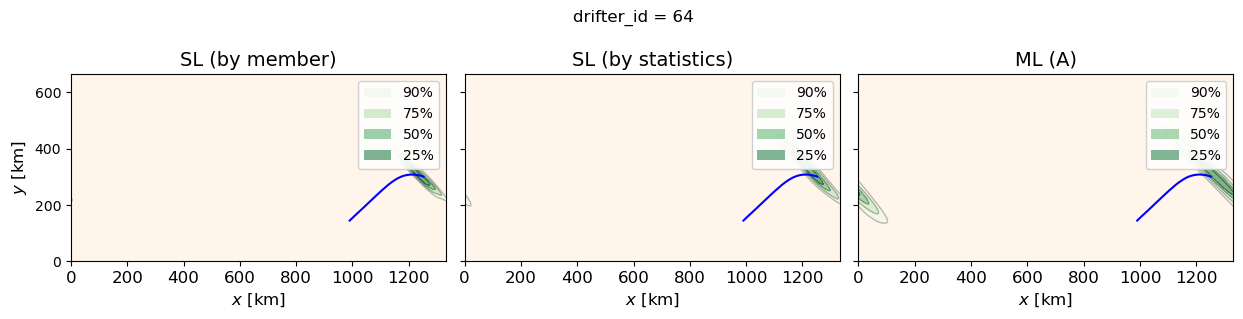

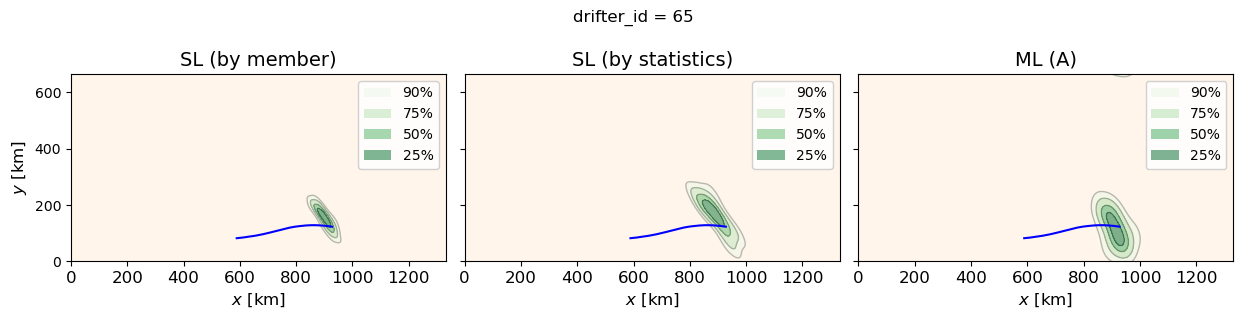

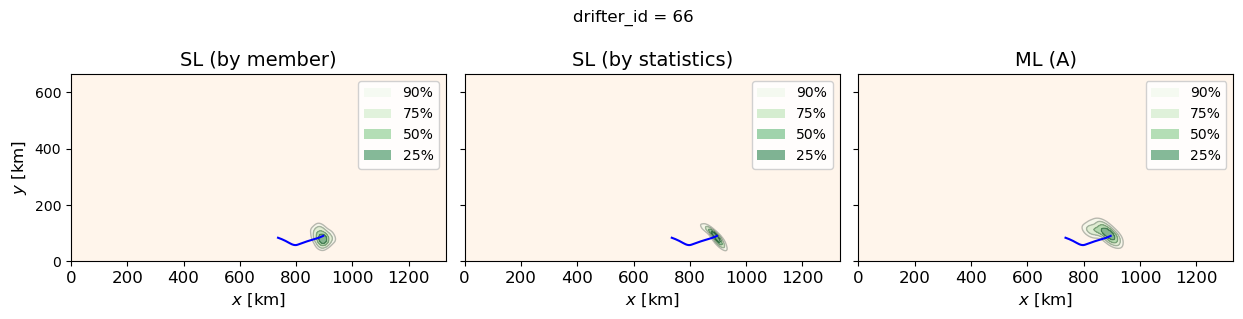

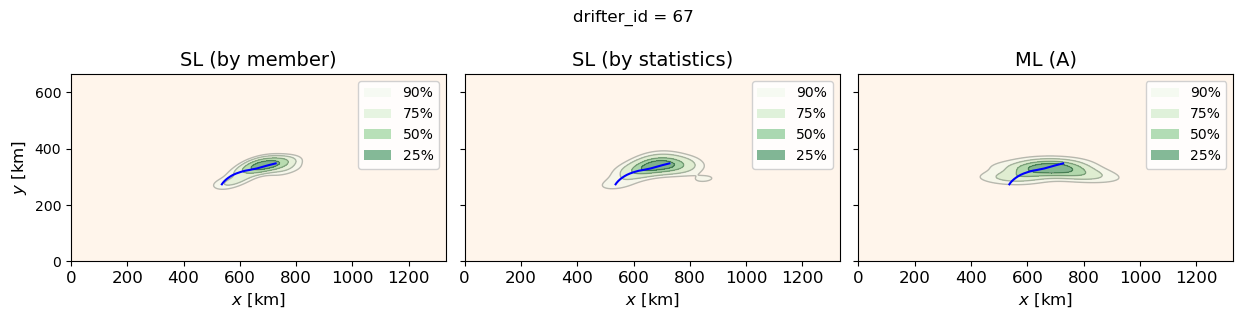

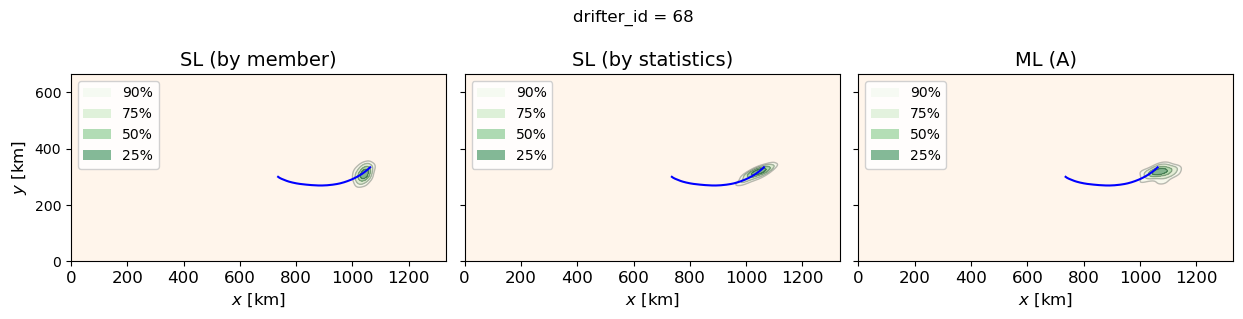

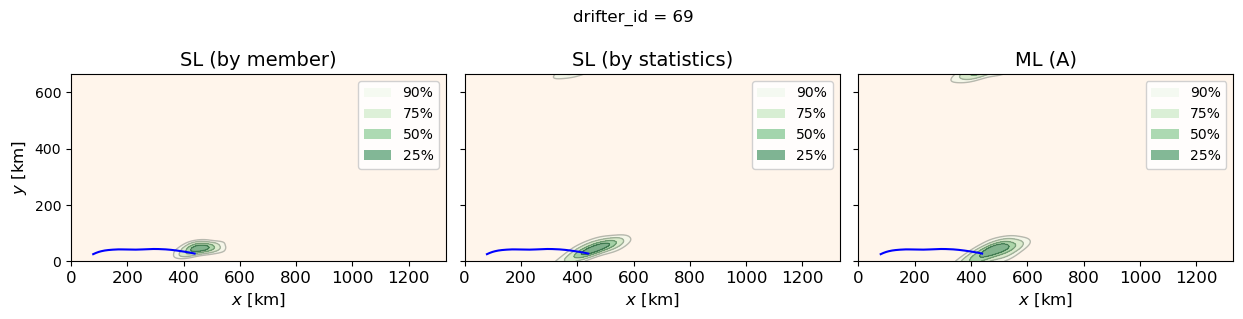

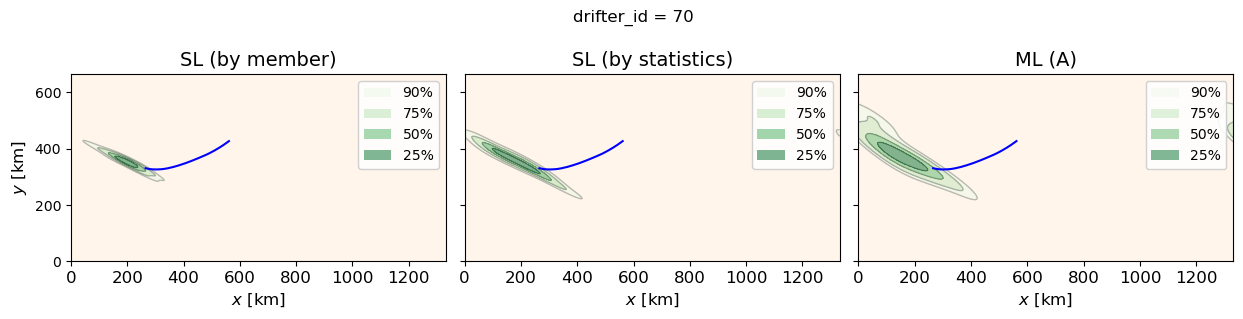

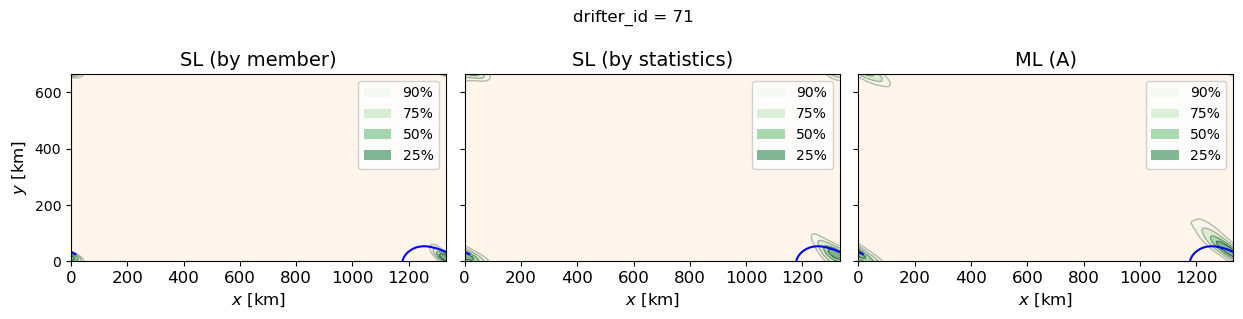

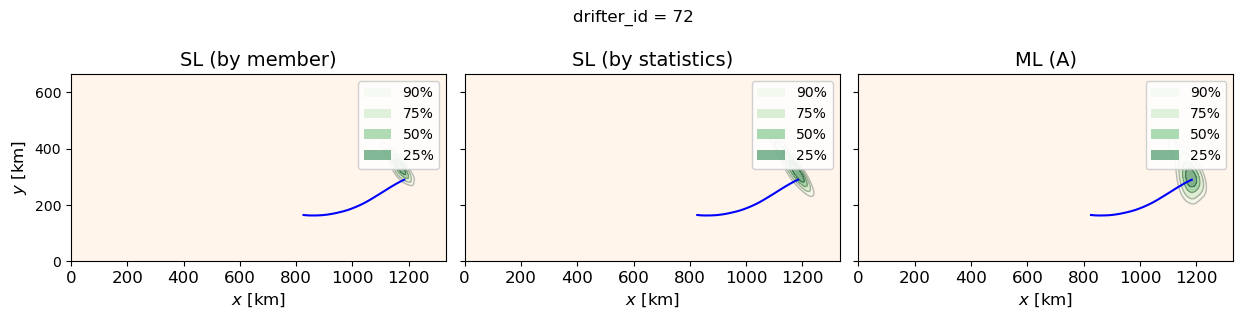

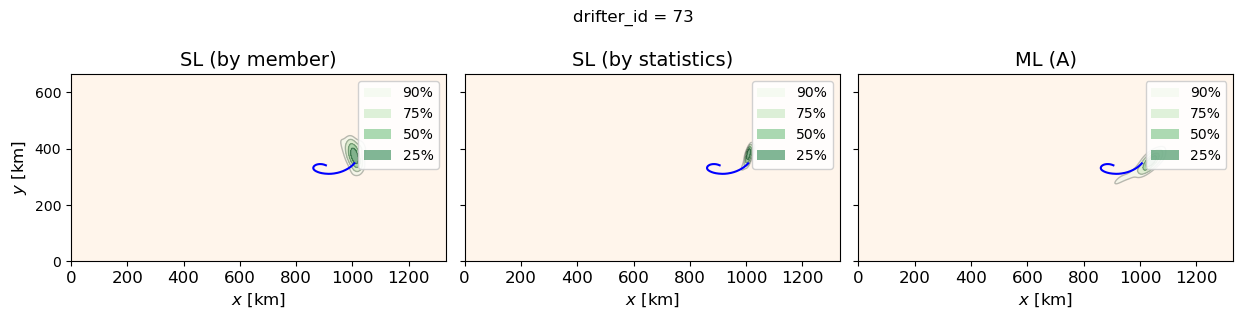

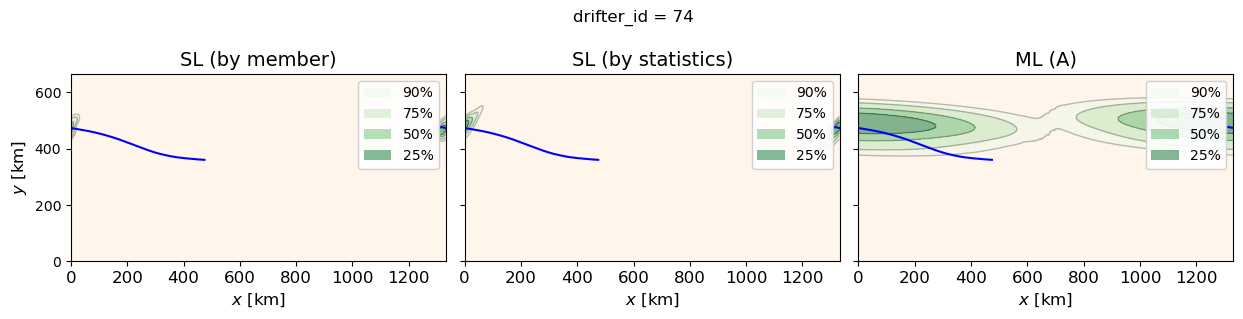

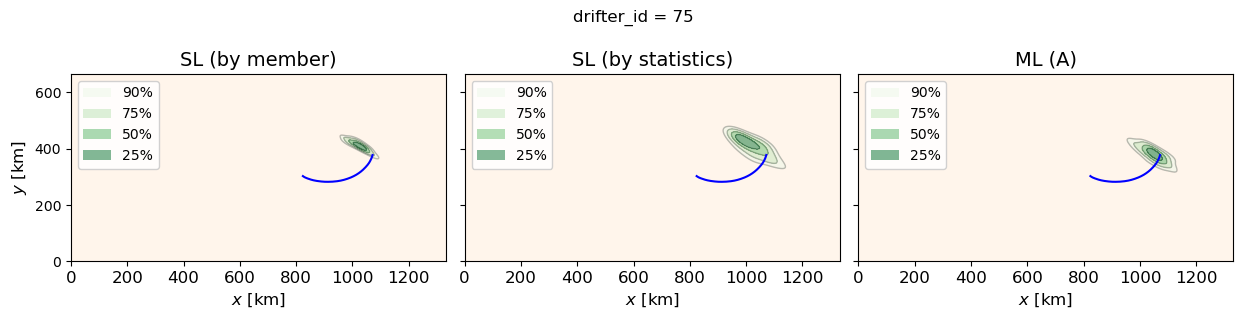

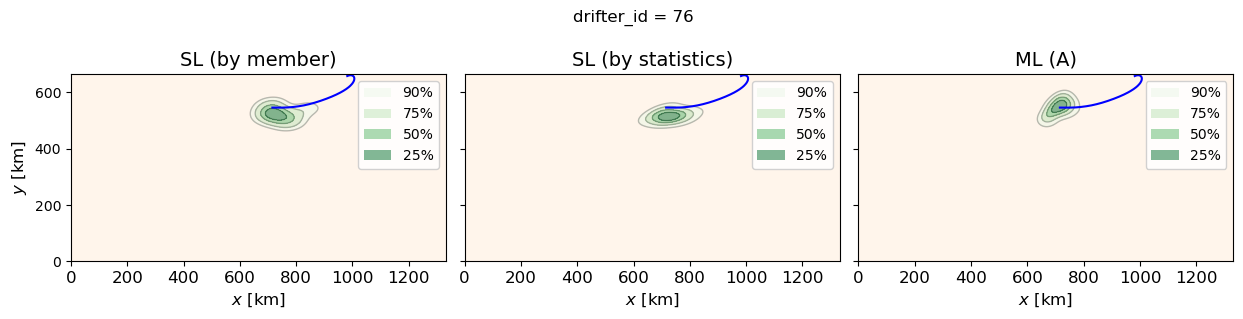

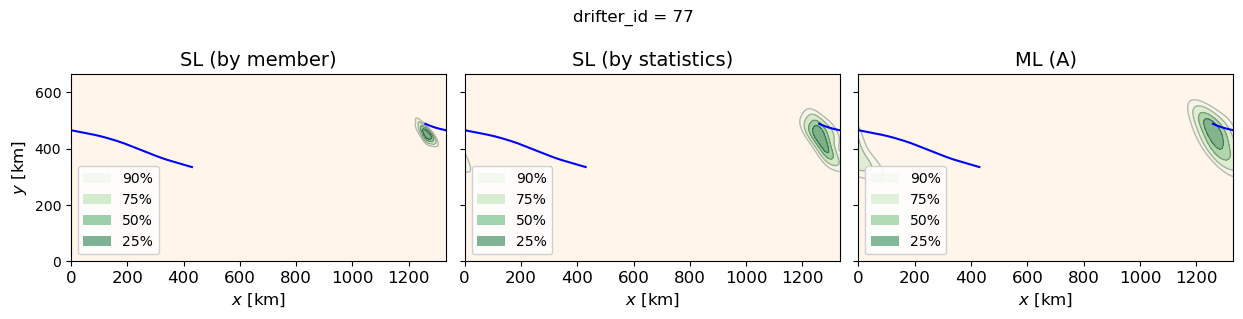

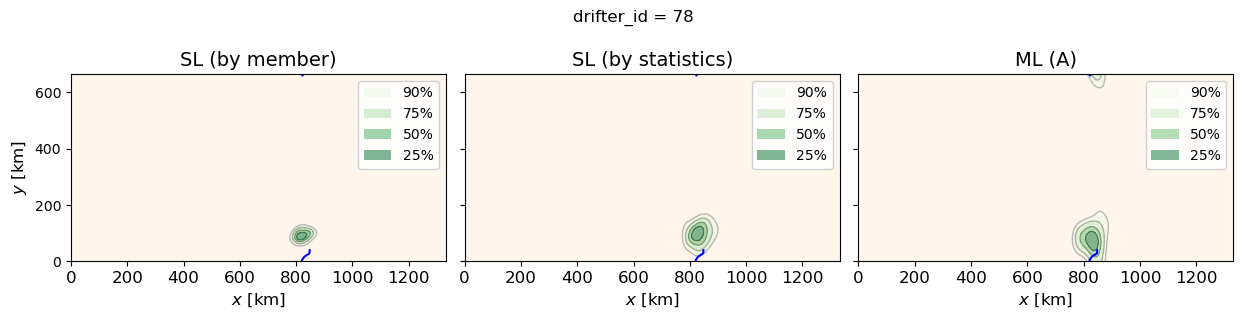

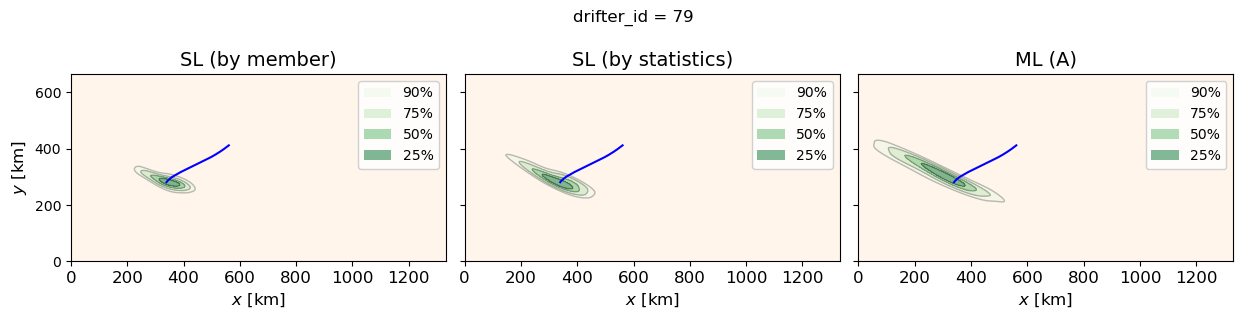

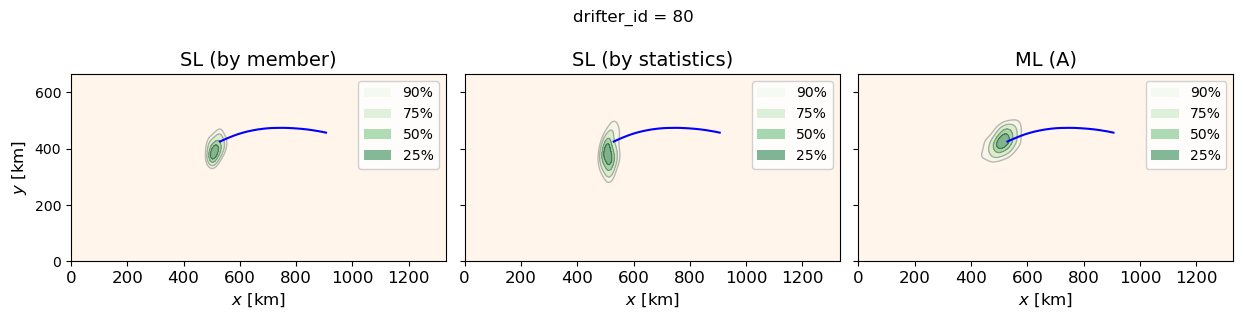

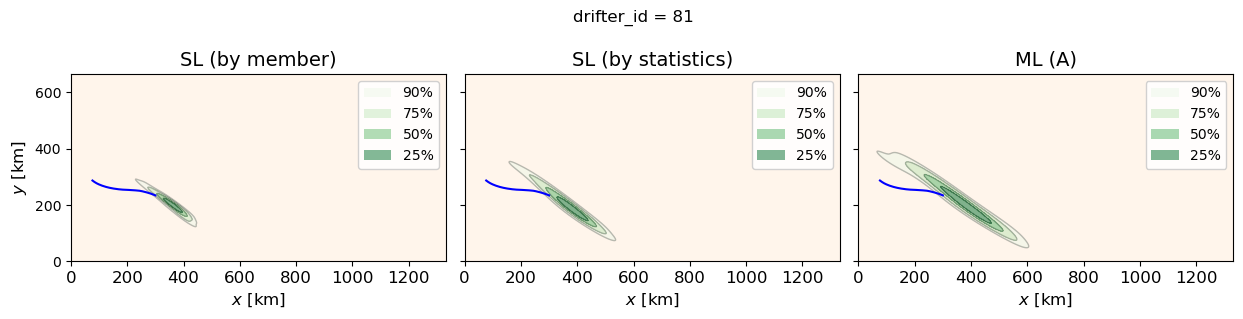

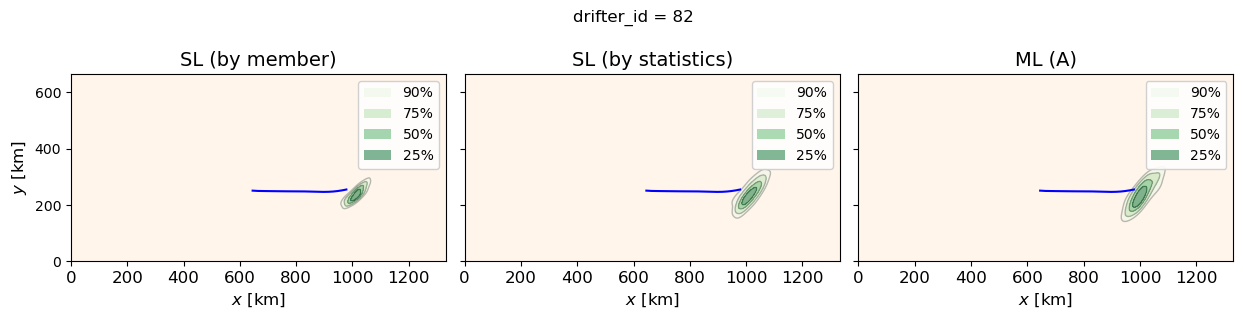

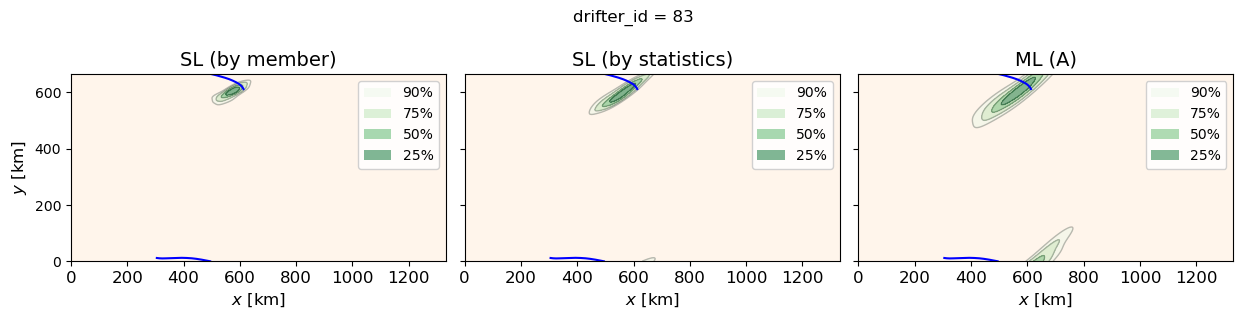

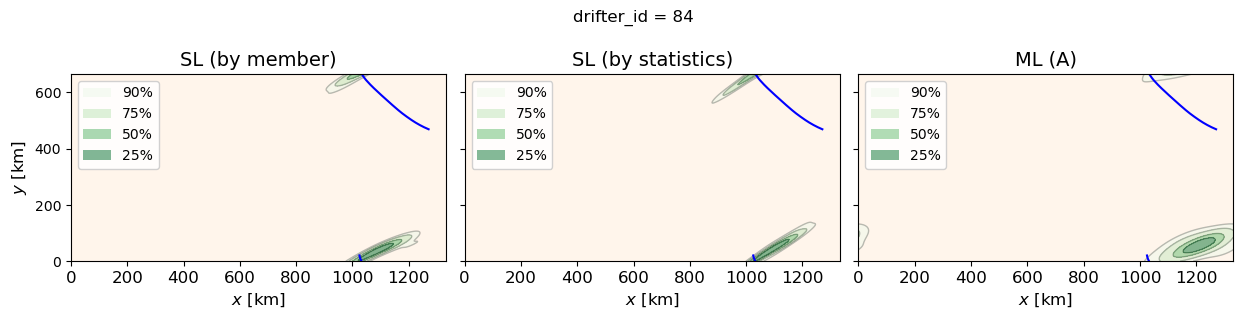

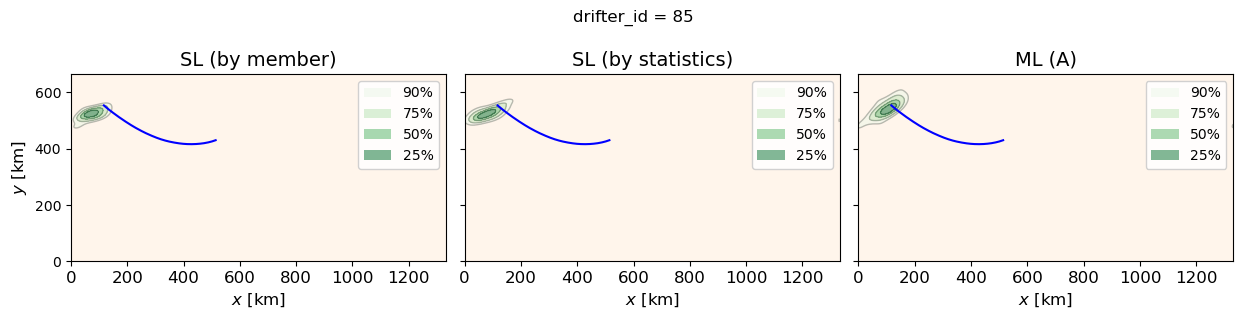

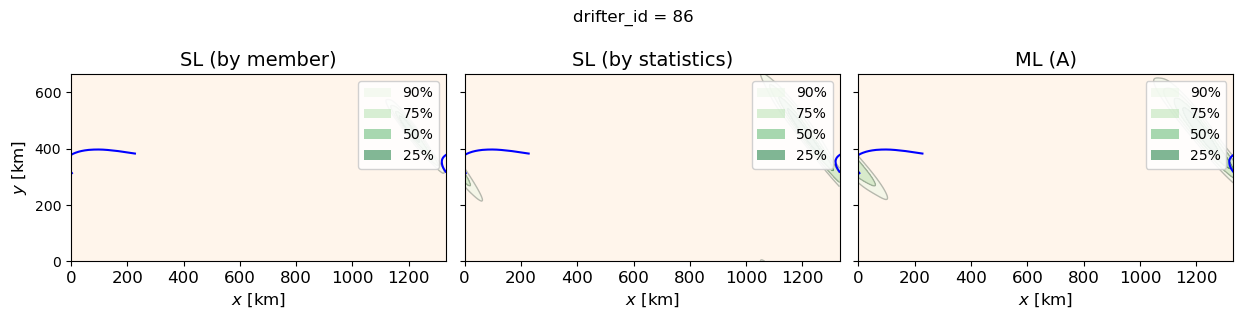

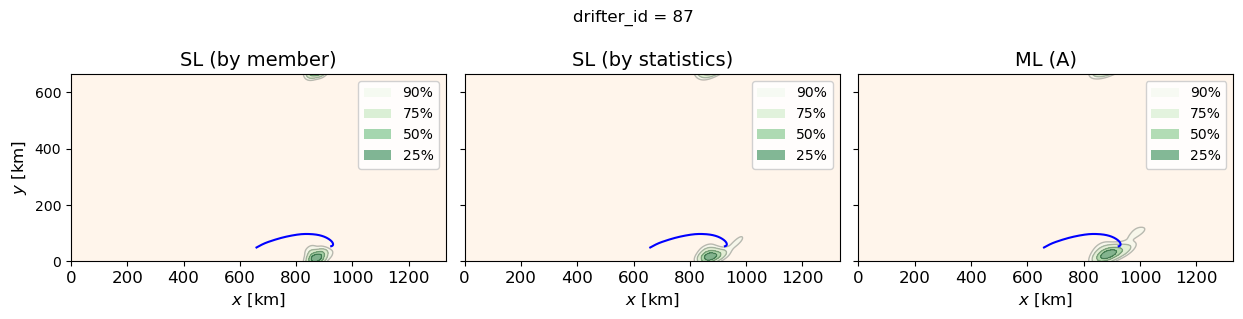

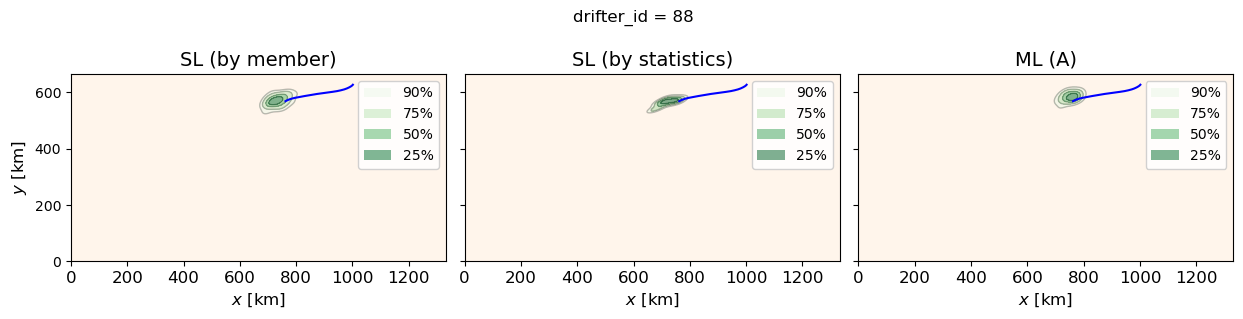

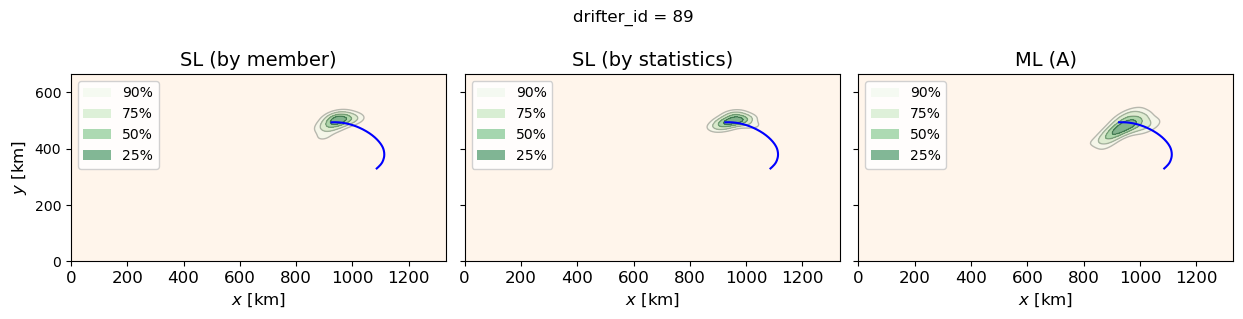

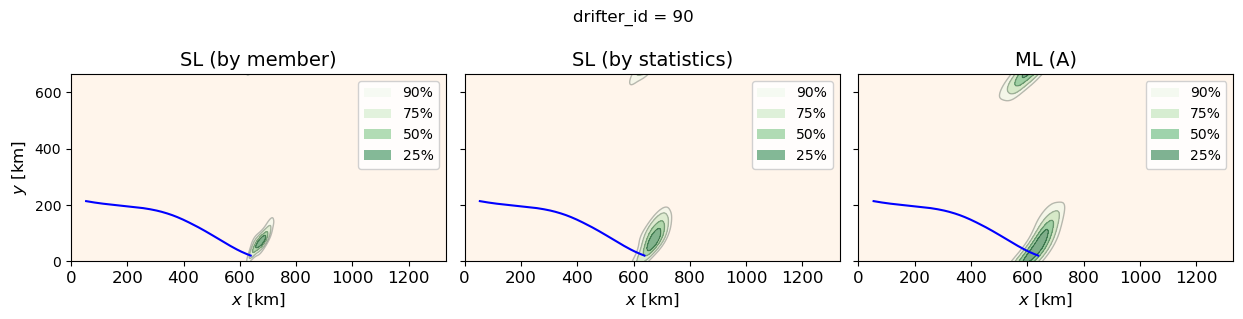

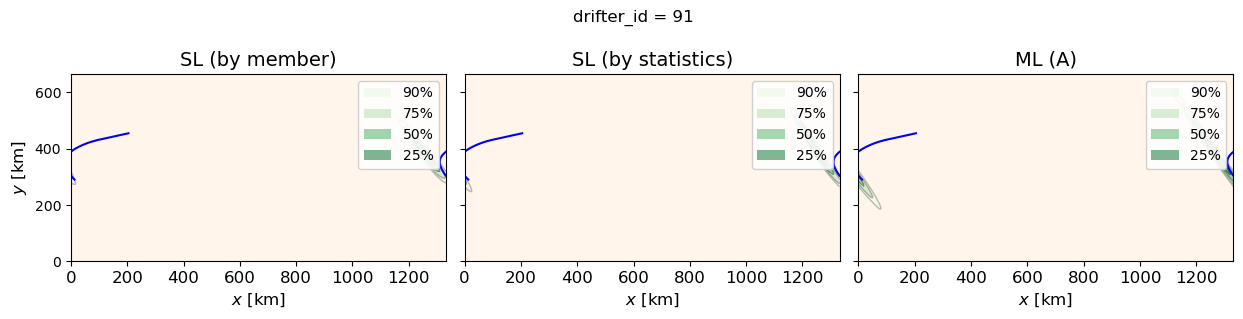

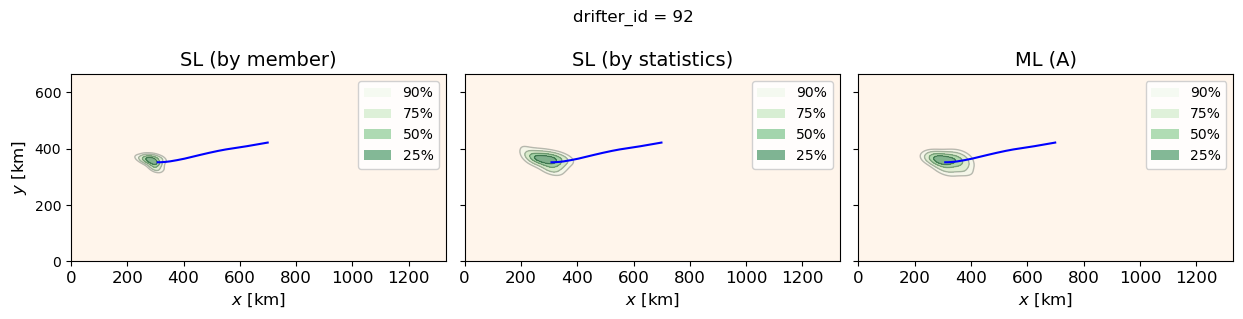

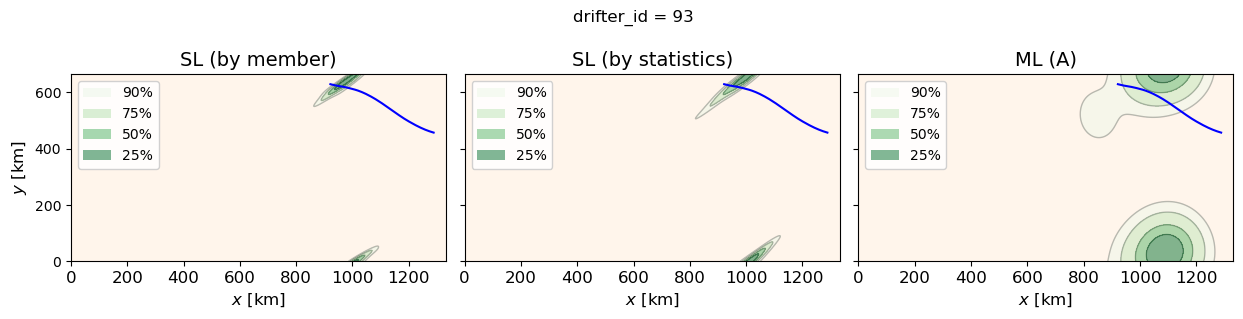

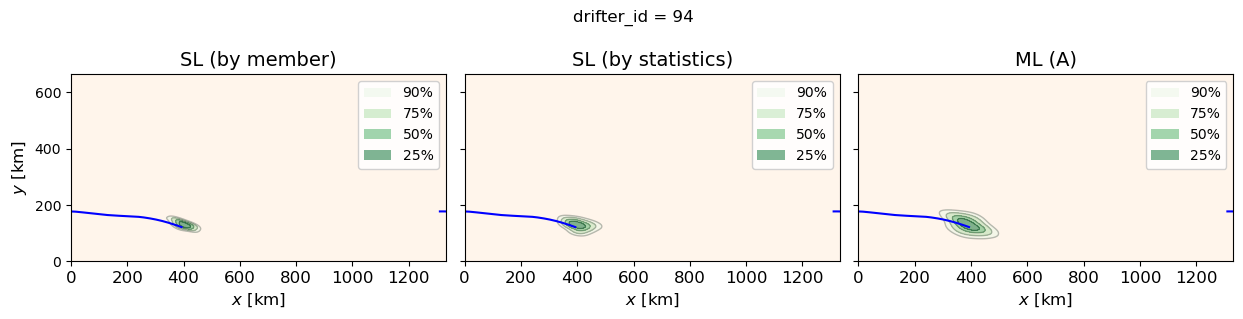

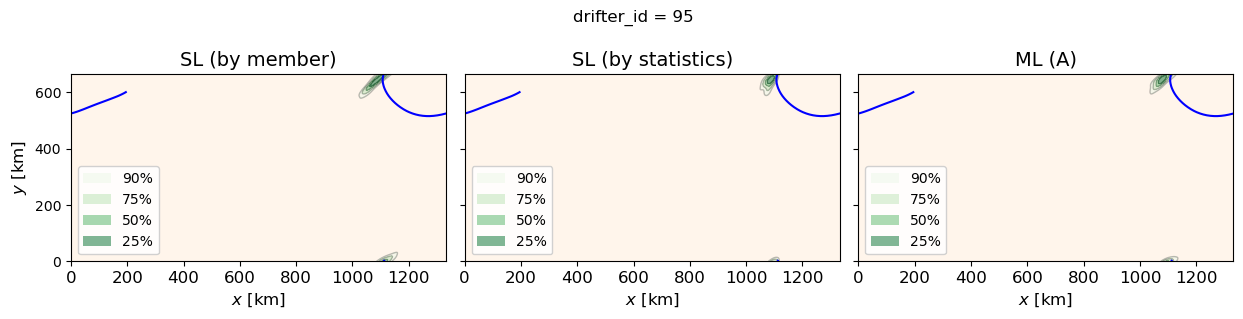

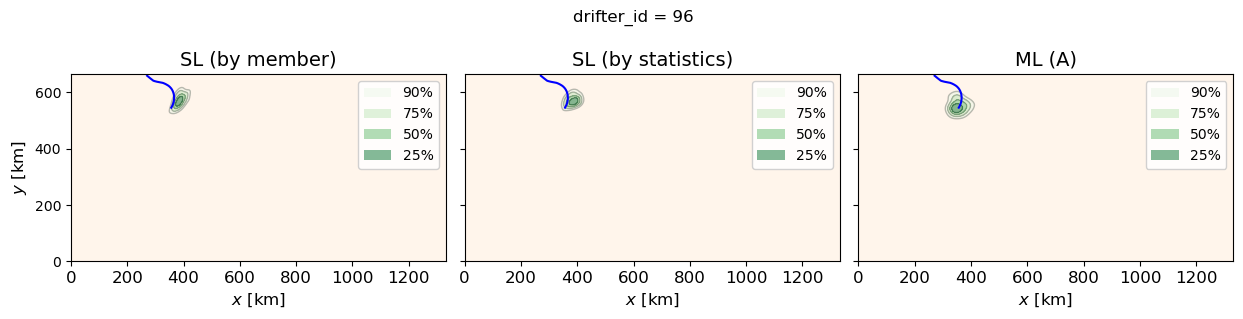

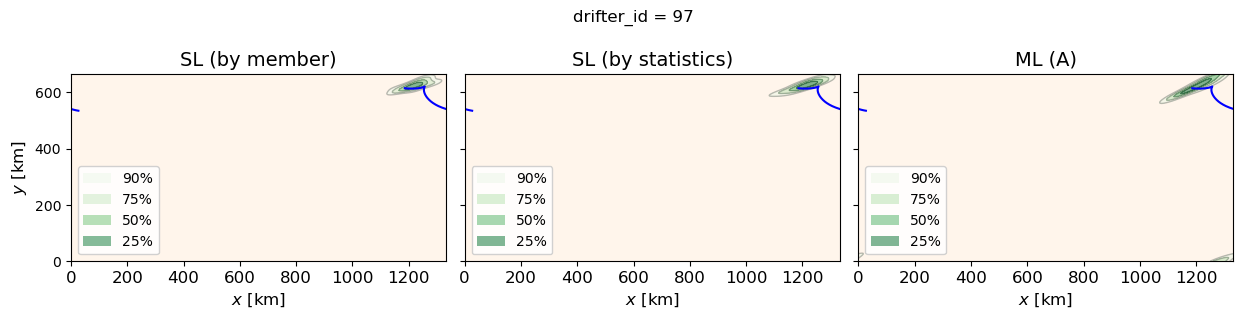

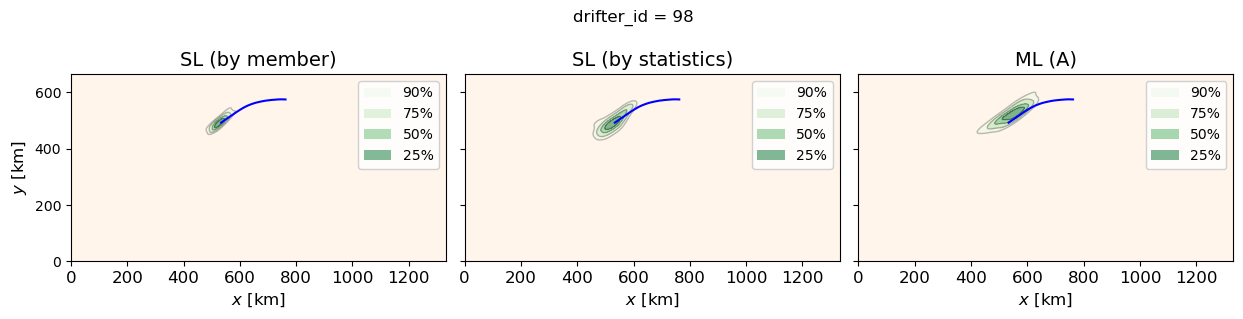

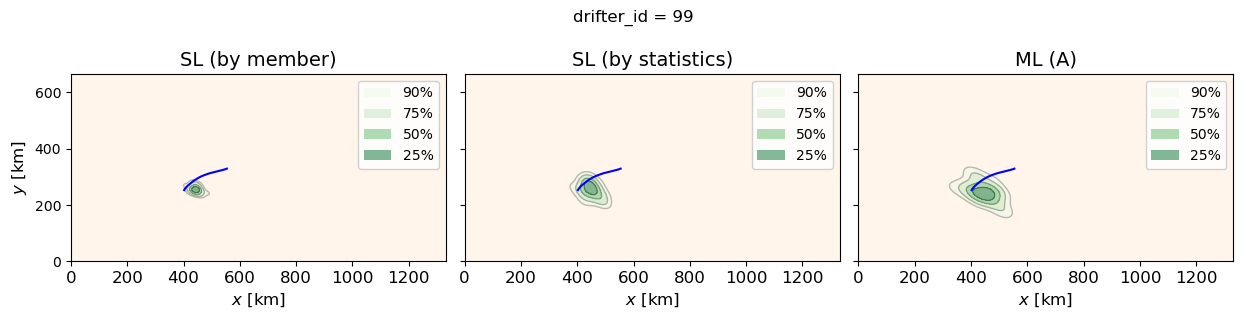

In [13]:
for d in range(100):
    fig = plt.figure(figsize=(15, 3.25))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], wspace=0.05)

    for i in range(3):
        ax = plt.subplot(gs[i])
        DrifterPlotHelper.background_from_grid_parameters(doubleJetCase_args["nx"], doubleJetCase_args["ny"], doubleJetCase_args["dx"], doubleJetCase_args["dy"], ax=ax)
        DrifterPlotHelper.add_drifter_on_background(ax, true_trajectories, drifter_id=d)

        if i == 0:
            DrifterPlotHelper.add_kde_on_background(ax, slda_trajectories,       drifter_id=d)
            ax.set_title("SL (by member)", fontsize=14)
        if i == 1:
            DrifterPlotHelper.add_kde_on_background(ax, slda_trajectories2[:50], drifter_id=d)
            ax.set_title("SL (by statistics)", fontsize=14)
        if i == 2:
            DrifterPlotHelper.add_kde_on_background(ax, mlda_trajectories[:50] , drifter_id=d)
            ax.set_title("ML (A)", fontsize=14)

        ax.tick_params(axis='x', labelsize=12)
        ax.set_xlabel(r"$x$ [km]", fontsize=12)
        if i>0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(r"$y$ [km]", fontsize=12)

    fig.suptitle("drifter_id = "+str(d))
    plt.tight_layout()


/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


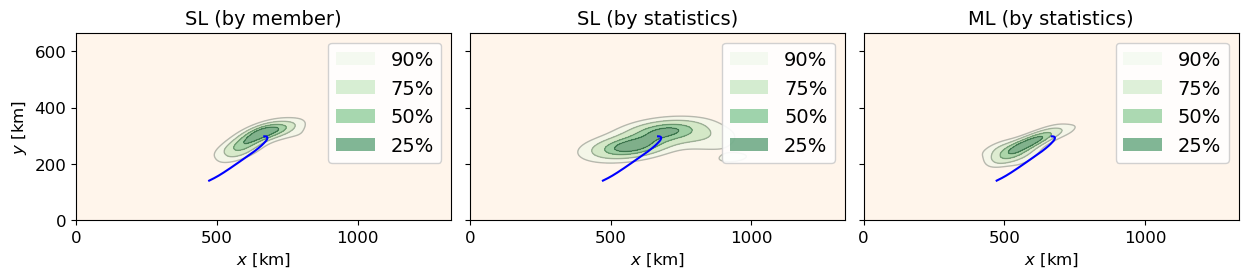

In [22]:
d = 15

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 4.5))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], wspace=0.05)
plt.rc('legend',fontsize=14)

for i in range(3):
    ax = plt.subplot(gs[i])
    DrifterPlotHelper.background_from_grid_parameters(doubleJetCase_args["nx"], doubleJetCase_args["ny"], doubleJetCase_args["dx"], doubleJetCase_args["dy"], ax=ax)
    DrifterPlotHelper.add_drifter_on_background(ax, true_trajectories, drifter_id=d)

    if i == 0:
        DrifterPlotHelper.add_kde_on_background(ax, slda_trajectories,       drifter_id=d)
        ax.set_title("SL (by member)", fontsize=14)
    if i == 1:
        DrifterPlotHelper.add_kde_on_background(ax, slda_trajectories2[:50], drifter_id=d)
        ax.set_title("SL (by statistics)", fontsize=14)
    if i == 2:
        DrifterPlotHelper.add_kde_on_background(ax, mlda_trajectories[:50] , drifter_id=d)
        ax.set_title("ML (by statistics)", fontsize=14)

    ax.tick_params(axis='x', labelsize=12)
    ax.set_xlabel(r"$x$ [km]", fontsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xticks([0, 500, 1000])
    if i>0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel(r"$y$ [km]", fontsize=12)

plt.tight_layout()

plt.savefig("DoubleJet-DA-PostProcessing-DriftersKDE4paper_"+str(d)+".pdf", bbox_inches="tight", dpi=300)